## Deep Reinforcement Learning Trading System

### Environment Setup and Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Reinforcement Learning
import gym
from gym import spaces

# Interactive Brokers API
try:
    from ib_insync import *
    IB_AVAILABLE = True
    print("Interactive Brokers API available")
except ImportError:
    print("Interactive Brokers API not available. Install with: pip install ib-insync")
    IB_AVAILABLE = False

# Data handling
from datetime import datetime, timedelta
import time
import random
from typing import Any, Dict, Tuple, List, Optional

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("Environment setup complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Interactive Brokers API available
Environment setup complete
PyTorch version: 2.8.0
CUDA available: False


### Interactive Brokers Connection Setup

In [28]:
class IBConnection:
    """Interactive Brokers connection handler for demo trading"""
    
    def __init__(self, host='127.0.0.1', port=7497, client_id=1):
        """
        Initialise IB connection for demo account
        Default port 7497 is for paper trading (demo)
        Port 7496 is for live trading
        """
        self.ib = IB()
        self.host = host
        self.port = port
        self.client_id = client_id
        self.connected = False
        
    def connect(self):
        """Connect to Interactive Brokers TWS or Gateway"""
        try:
            if not IB_AVAILABLE:
                print("Interactive Brokers API not installed")
                return False
                
            self.ib.connect(self.host, self.port, clientId=self.client_id)
            self.connected = True
            print(f"Connected to IB on port {self.port} (Paper Trading)")
            return True
        except Exception as e:
            print(f"Failed to connect to IB: {e}")
            return False
    
    def disconnect(self):
        """Disconnect from Interactive Brokers"""
        if self.connected:
            self.ib.disconnect()
            self.connected = False
            print("Disconnected from IB")
    
    def get_market_data(self, symbol: str, exchange: str = 'SMART', 
                       currency: str = 'USD') -> Optional[pd.DataFrame]:
        """Get real-time market data for a symbol"""
        if not self.connected:
            print("Not connected to IB")
            return None
            
        try:
            contract = Stock(symbol, exchange, currency)
            self.ib.qualifyContracts(contract)
            
            # Get market data
            ticker = self.ib.reqMktData(contract)
            self.ib.sleep(2)  # Wait for data
            
            if ticker.last:
                return {
                    'symbol': symbol,
                    'last': ticker.last,
                    'bid': ticker.bid,
                    'ask': ticker.ask,
                    'volume': ticker.volume,
                    'timestamp': datetime.now()
                }
            return None
        except Exception as e:
            print(f"Error getting market data: {e}")
            return None
    
    def place_order(self, symbol: str, action: str, quantity: int, 
                   order_type: str = 'MKT') -> bool:
        """Place an order through IB"""
        if not self.connected:
            print("Not connected to IB")
            return False
            
        try:
            contract = Stock(symbol, 'SMART', 'USD')
            self.ib.qualifyContracts(contract)
            
            if order_type == 'MKT':
                order = MarketOrder(action, quantity)
            else:
                order = LimitOrder(action, quantity, 0)  # Would need price
                
            trade = self.ib.placeOrder(contract, order)
            print(f"Order placed: {action} {quantity} {symbol}")
            return True
        except Exception as e:
            print(f"Error placing order: {e}")
            return False

# Initialise IB connection (will use demo/paper trading)
ib_conn = IBConnection()
print("Interactive Brokers connection handler ready")
print("Remember: Ensure TWS/Gateway is running with demo account")

Interactive Brokers connection handler ready
Remember: Ensure TWS/Gateway is running with demo account


### Trading Environment Definition

In [29]:
class TradingEnvironment(gym.Env):
    """Custom trading environment following the MDP framework from the article"""
    
    def __init__(self, data: pd.DataFrame, initial_balance: float = 10000,
                 transaction_cost: float = 0.001, lookback_window: int = 20):
        super(TradingEnvironment, self).__init__()
        
        # Data and market parameters
        self.data = data.reset_index(drop=True)
        self.lookback_window = lookback_window
        self.transaction_cost = transaction_cost
        
        # Account parameters
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.position = 0  # -1: short, 0: neutral, 1: long
        self.shares_held = 0
        self.current_step = lookback_window
        self.max_steps = len(data) - 1
        
        # Action space: 0=Hold, 1=Buy, 2=Sell
        self.action_space = spaces.Discrete(3)
        
        # Observation space: price features + position info
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(lookback_window + 3,), dtype=np.float32
        )
        
        # Performance tracking
        self.net_worths = []
        self.trades = []
        
    def reset(self):
        """Reset environment to initial state"""
        self.balance = self.initial_balance
        self.position = 0
        self.shares_held = 0
        self.current_step = self.lookback_window
        self.net_worths = [self.initial_balance]
        self.trades = []
        
        return self._get_observation()
    
    def _get_observation(self):
        """Get current market state observation"""
        # Price features (returns over lookback window)
        start_idx = self.current_step - self.lookback_window
        end_idx = self.current_step
        
        prices = self.data['close'][start_idx:end_idx].values
        returns = np.diff(prices) / prices[:-1]  # Price changes
        
        # Pad if necessary
        if len(returns) < self.lookback_window:
            returns = np.pad(returns, (self.lookback_window - len(returns), 0))
        
        # Current position information
        current_price = self.data['close'][self.current_step]
        position_value = self.shares_held * current_price
        total_value = self.balance + position_value
        
        # Combine features
        obs = np.concatenate([
            returns,
            [self.position / 2,  # Normalised position (-0.5 to 0.5)
             position_value / self.initial_balance,  # Position value ratio
             self.balance / self.initial_balance]  # Cash ratio
        ])
        
        return obs.astype(np.float32)
    
    def step(self, action):
        """Execute one trading step"""
        current_price = self.data['close'][self.current_step]
        
        # Execute action
        reward = 0
        done = False
        info = {}
        
        # Action mapping: 0=Hold, 1=Buy, 2=Sell
        if action == 1:  # Buy
            reward = self._execute_buy(current_price)
        elif action == 2:  # Sell
            reward = self._execute_sell(current_price)
        # action == 0 is hold, no execution needed
        
        # Move to next step
        self.current_step += 1
        
        # Calculate current net worth
        position_value = self.shares_held * current_price
        net_worth = self.balance + position_value
        self.net_worths.append(net_worth)
        
        # Check if episode is done
        if self.current_step >= self.max_steps:
            done = True
            # Final liquidation
            if self.shares_held != 0:
                self.balance += self.shares_held * current_price * (1 - self.transaction_cost)
                self.shares_held = 0
                self.position = 0
        
        # Calculate step reward (portfolio return)
        if len(self.net_worths) > 1:
            step_return = (self.net_worths[-1] - self.net_worths[-2]) / self.net_worths[-2]
            reward += step_return * 100  # Scale reward
        
        next_obs = self._get_observation() if not done else np.zeros(self.observation_space.shape)
        
        info = {
            'net_worth': net_worth,
            'position': self.position,
            'balance': self.balance,
            'shares_held': self.shares_held
        }
        
        return next_obs, reward, done, info
    
    def _execute_buy(self, price):
        """Execute buy order"""
        if self.position >= 0 and self.balance > price * 100:  # Minimum 100 shares
            # Calculate shares to buy (use 95% of available balance)
            max_shares = int((self.balance * 0.95) / price)
            if max_shares > 0:
                cost = max_shares * price * (1 + self.transaction_cost)
                self.balance -= cost
                self.shares_held += max_shares
                self.position = 1
                
                self.trades.append({
                    'step': self.current_step,
                    'action': 'BUY',
                    'shares': max_shares,
                    'price': price,
                    'cost': cost
                })
                return 0.1  # Small positive reward for executing trade
        return -0.01  # Small penalty for invalid action
    
    def _execute_sell(self, price):
        """Execute sell order"""
        if self.position <= 0 and self.shares_held > 0:
            # Sell all shares
            revenue = self.shares_held * price * (1 - self.transaction_cost)
            self.balance += revenue
            sold_shares = self.shares_held
            self.shares_held = 0
            self.position = -1
            
            self.trades.append({
                'step': self.current_step,
                'action': 'SELL',
                'shares': sold_shares,
                'price': price,
                'revenue': revenue
            })
            return 0.1  # Small positive reward for executing trade
        return -0.01  # Small penalty for invalid action
    
    def get_performance_metrics(self):
        """Calculate performance metrics"""
        if len(self.net_worths) < 2:
            return {}
            
        returns = np.diff(self.net_worths) / self.net_worths[:-1]
        
        total_return = (self.net_worths[-1] - self.net_worths[0]) / self.net_worths[0]
        
        metrics = {
            'total_return': total_return * 100,
            'annualised_return': (1 + total_return) ** (252 / len(returns)) - 1,
            'volatility': np.std(returns) * np.sqrt(252) * 100,
            'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252),
            'max_drawdown': self._calculate_max_drawdown(),
            'total_trades': len(self.trades)
        }
        
        return metrics
    
    def _calculate_max_drawdown(self):
        """Calculate maximum drawdown"""
        peak = self.net_worths[0]
        max_dd = 0
        
        for value in self.net_worths:
            if value > peak:
                peak = value
            dd = (peak - value) / peak
            if dd > max_dd:
                max_dd = dd
                
        return max_dd * 100

print("Trading environment defined successfully")

Trading environment defined successfully


### Deep Q-Network (DQN) Implementation

In [30]:
class DQN(nn.Module):
    """Deep Q-Network for trading decisions"""
    
    def __init__(self, input_size: int, hidden_size: int = 128, output_size: int = 3):
        super(DQN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

class ReplayBuffer:
    """Experience replay buffer for DQN training"""
    
    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int):
        """Sample batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.BoolTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    """DQN Agent for trading"""
    
    def __init__(self, state_size: int, action_size: int = 3, lr: float = 0.001,
                 gamma: float = 0.95, epsilon: float = 1.0, epsilon_decay: float = 0.995,
                 epsilon_min: float = 0.01, memory_size: int = 10000):
        
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Neural networks
        self.q_network = DQN(state_size, 128, action_size)
        self.target_network = DQN(state_size, 128, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experience replay
        self.memory = ReplayBuffer(memory_size)
        self.update_target_frequency = 1000
        self.steps = 0
        
        # Copy weights to target network
        self.update_target_network()
    
    def update_target_network(self):
        """Update target network weights"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def act(self, state, training: bool = True):
        """Choose action using epsilon-greedy policy"""
        if training and np.random.random() <= self.epsilon:
            return random.choice(range(self.action_size))
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state_tensor)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)
    
    def replay(self, batch_size: int = 32):
        """Train the network on a batch of experiences"""
        if len(self.memory) < batch_size:
            return 0
        
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Next Q values from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimise
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # Update target network periodically
        self.steps += 1
        if self.steps % self.update_target_frequency == 0:
            self.update_target_network()
        
        return loss.item()
    
    def save_model(self, filepath: str):
        """Save model weights"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.steps
        }, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['steps']
        print(f"Model loaded from {filepath}")

print("DQN implementation complete")

DQN implementation complete


### Data Generation and Preparation

Preparing market data for 3-stock index fund...
Generated data for 3 stocks
STOCK_A: 1000 days, price range £79.52 to £253.02
STOCK_B: 1000 days, price range £13.07 to £100.18
STOCK_C: 1000 days, price range £43.78 to £159.16
Index fund data: 1000 days
Index value range: £53.86 to £137.32


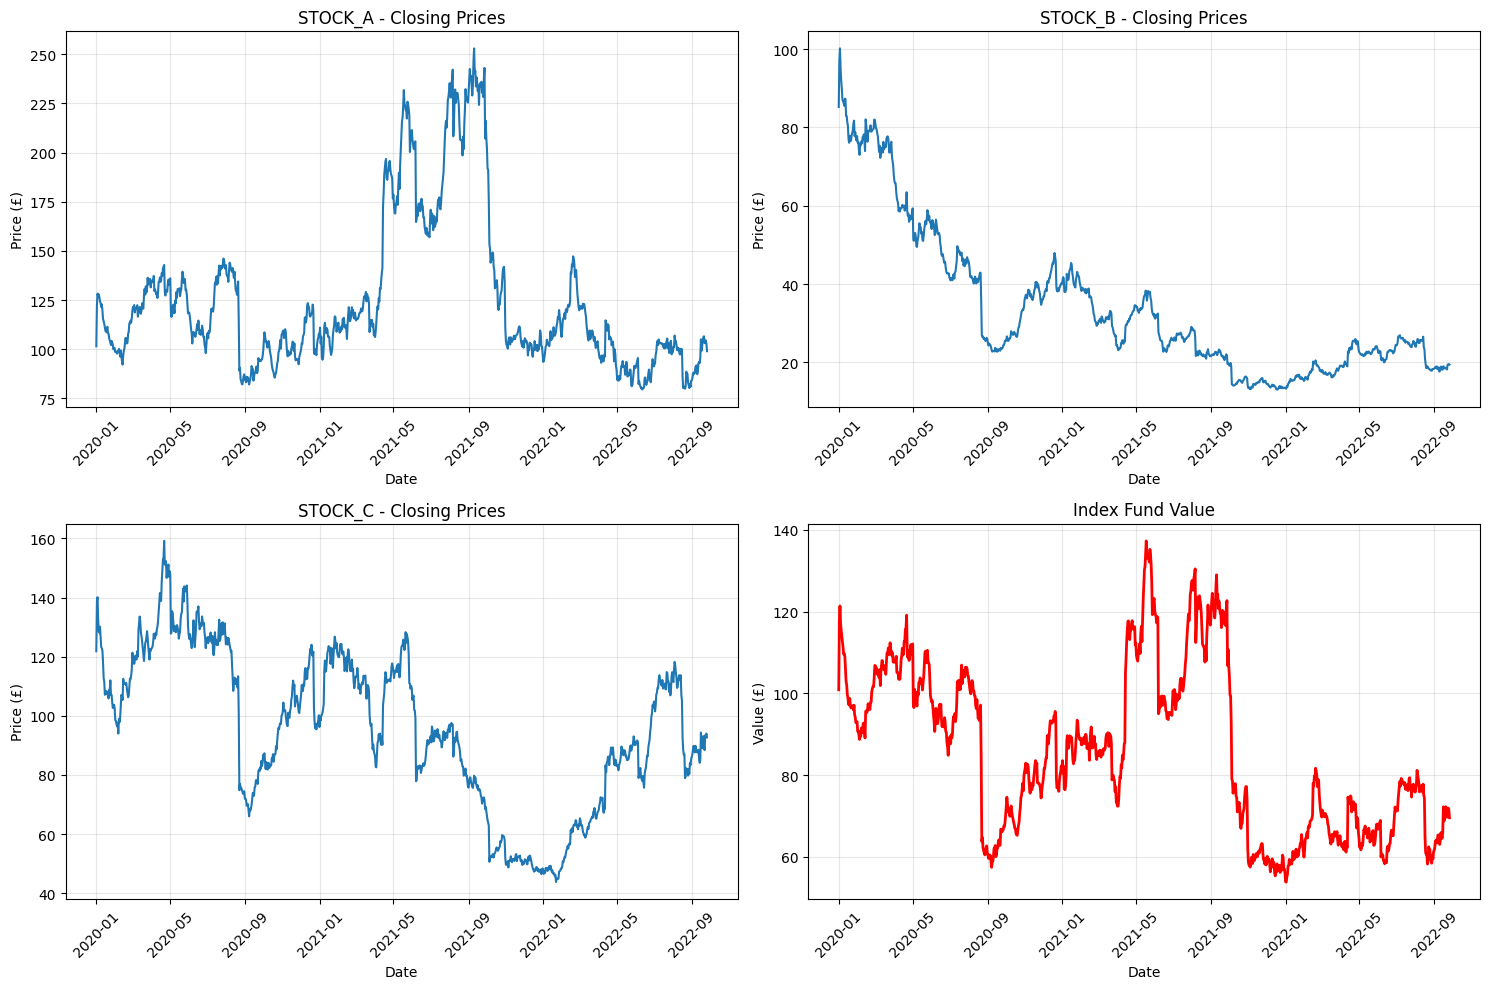

Training data: 800 days
Testing data: 200 days
Individual stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']


In [31]:
def generate_synthetic_price_data(n_days: int = 1000, stocks: List[Dict] = None):
    """Generate synthetic price data with realistic market patterns for multiple stocks"""
    np.random.seed(42)
    
    # Default 3-stock configuration for index fund
    if stocks is None:
        stocks = [
            {'symbol': 'STOCK_A', 'start_price': 100.0, 'weight': 0.4, 'drift': 0.0008, 'volatility': 0.025},
            {'symbol': 'STOCK_B', 'start_price': 85.0, 'weight': 0.35, 'drift': 0.0005, 'volatility': 0.020},
            {'symbol': 'STOCK_C', 'start_price': 120.0, 'weight': 0.25, 'drift': 0.0006, 'volatility': 0.018}
        ]
    
    dates = pd.date_range(start='2020-01-01', periods=n_days, freq='D')
    n_stocks = len(stocks)
    
    # Create correlation matrix for realistic stock movements
    correlation_matrix = np.full((n_stocks, n_stocks), 0.3)
    np.fill_diagonal(correlation_matrix, 1.0)
    
    # Generate correlated returns
    independent_returns = np.random.normal(0, 1, (n_days, n_stocks))
    chol = np.linalg.cholesky(correlation_matrix)
    correlated_returns = independent_returns @ chol.T
    
    # Apply individual stock parameters
    for i, stock in enumerate(stocks):
        correlated_returns[:, i] = (correlated_returns[:, i] * stock['volatility'] + stock['drift'])
    
    # Add market regime changes affecting all stocks
    regime_changes = np.random.choice([0, 1], n_days, p=[0.95, 0.05])
    market_shock = np.random.normal(0, 0.01, n_days)
    market_shock[regime_changes == 1] *= 5
    
    for i in range(n_stocks):
        correlated_returns[:, i] += market_shock
        correlated_returns[regime_changes == 1, i] *= 2
    
    # Add momentum effects
    momentum = np.zeros_like(correlated_returns)
    for i in range(5, n_days):
        for j in range(n_stocks):
            momentum[i, j] = np.mean(correlated_returns[i-5:i, j]) * 0.1
    correlated_returns += momentum
    
    # Generate stock data and index fund data
    stock_data = {}
    index_values = []
    
    for i, stock in enumerate(stocks):
        # Generate prices for this stock
        prices = [stock['start_price']]
        for ret in correlated_returns[:, i]:
            prices.append(prices[-1] * (1 + ret))
        
        # Create OHLC data for this stock
        stock_df = pd.DataFrame({
            'date': dates,
            'open': prices[:-1],
            'high': [p * (1 + abs(np.random.normal(0, 0.01))) for p in prices[:-1]],
            'low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in prices[:-1]],
            'close': prices[1:],
            'volume': np.random.randint(1000000, 5000000, n_days)
        })
        
        # Ensure high >= close >= low and high >= open >= low
        stock_df['high'] = np.maximum(stock_df['high'], np.maximum(stock_df['open'], stock_df['close']))
        stock_df['low'] = np.minimum(stock_df['low'], np.minimum(stock_df['open'], stock_df['close']))
        
        stock_data[stock['symbol']] = stock_df
    
    # Calculate index fund values based on weighted average
    for day_idx in range(n_days):
        daily_index_value = 0.0
        for stock in stocks:
            daily_price = stock_data[stock['symbol']]['close'].iloc[day_idx]
            daily_index_value += stock['weight'] * daily_price
        index_values.append(daily_index_value)
    
    # Create index fund dataframe
    index_data = pd.DataFrame({
        'date': dates,
        'open': index_values,  # Simplified for index
        'high': index_values,
        'low': index_values,
        'close': index_values,
        'volume': sum(stock_data[stock['symbol']]['volume'] for stock in stocks) // len(stocks)
    })
    
    return stock_data, index_data

def fetch_real_data_ib(symbols: List[str] = None, days: int = 365):
    """Fetch real market data from Interactive Brokers for multiple stocks"""
    if symbols is None:
        symbols = ['NVDA', 'AAPL', 'MSFT']
    
    if not ib_conn.connect():
        print("Using synthetic data instead")
        return generate_synthetic_price_data()
    
    try:
        all_stock_data = {}
        
        for symbol in symbols:
            contract = Stock(symbol, 'SMART', 'USD')
            ib_conn.ib.qualifyContracts(contract)
            
            # Fetch historical data for this stock
            bars = ib_conn.ib.reqHistoricalData(
                contract,
                endDateTime='',
                durationStr=f'{days} D',
                barSizeSetting='1 day',
                whatToShow='TRADES',
                useRTH=True,
                formatDate=1
            )
            
            if bars:
                data = pd.DataFrame([{
                    'date': bar.date,
                    'open': bar.open,
                    'high': bar.high,
                    'low': bar.low,
                    'close': bar.close,
                    'volume': bar.volume
                } for bar in bars])
                
                all_stock_data[symbol] = data
                print(f"Fetched {len(data)} days of data for {symbol}")
            else:
                print(f"No data received for {symbol}")
        
        if not all_stock_data:
            print("No real data available, using synthetic data")
            return generate_synthetic_price_data()
        
        # Calculate index fund from real data (equal weights)
        weight_per_stock = 1.0 / len(all_stock_data)
        dates = next(iter(all_stock_data.values()))['date']
        index_values = []
        
        for i in range(len(dates)):
            daily_index_value = 0.0
            for symbol, stock_df in all_stock_data.items():
                daily_price = stock_df['close'].iloc[i]
                daily_index_value += weight_per_stock * daily_price
            index_values.append(daily_index_value)
        
        index_data = pd.DataFrame({
            'date': dates,
            'open': index_values,
            'high': index_values,
            'low': index_values,
            'close': index_values,
            'volume': sum(all_stock_data[symbol]['volume'] for symbol in all_stock_data) // len(all_stock_data)
        })
        
        return all_stock_data, index_data
            
    except Exception as e:
        print(f"Error fetching data: {e}")
        print("Using synthetic data instead")
        return generate_synthetic_price_data()
    finally:
        ib_conn.disconnect()

def prepare_training_data(stock_data: Dict, index_data: pd.DataFrame, train_ratio: float = 0.8):
    """Split data into training and testing sets for all stocks and index"""
    n_total = len(index_data)
    split_idx = int(n_total * train_ratio)
    
    # Split individual stock data
    train_stock_data = {}
    test_stock_data = {}
    for symbol, data in stock_data.items():
        train_stock_data[symbol] = data[:split_idx].copy()
        test_stock_data[symbol] = data[split_idx:].copy()
    
    # Split index data
    train_index_data = index_data[:split_idx].copy()
    test_index_data = index_data[split_idx:].copy()
    
    print(f"Training data: {split_idx} days")
    print(f"Testing data: {n_total - split_idx} days")
    print(f"Individual stocks: {list(stock_data.keys())}")
    
    return train_stock_data, test_stock_data, train_index_data, test_index_data

# Generate or fetch data
print("Preparing market data for 3-stock index fund...")
stock_data, index_data = generate_synthetic_price_data(n_days=1000)

# Display data information
print(f"Generated data for {len(stock_data)} stocks")
for symbol, data in stock_data.items():
    print(f"{symbol}: {data.shape[0]} days, price range £{data['close'].min():.2f} to £{data['close'].max():.2f}")

print(f"Index fund data: {index_data.shape[0]} days")
print(f"Index value range: £{index_data['close'].min():.2f} to £{index_data['close'].max():.2f}")

# Visualise the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot individual stocks
stock_symbols = list(stock_data.keys())
for i, symbol in enumerate(stock_symbols):
    if i < 3:  # Plot first 3 stocks
        row = i // 2
        col = i % 2
        axes[row, col].plot(stock_data[symbol]['date'], stock_data[symbol]['close'])
        axes[row, col].set_title(f'{symbol} - Closing Prices')
        axes[row, col].set_xlabel('Date')
        axes[row, col].set_ylabel('Price (£)')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].grid(True, alpha=0.3)

# Plot index fund
axes[1, 1].plot(index_data['date'], index_data['close'], color='red', linewidth=2)
axes[1, 1].set_title('Index Fund Value')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Value (£)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Split data
train_stock_data, test_stock_data, train_index_data, test_index_data = prepare_training_data(
    stock_data, index_data
)

### Training the DQN Agent

In [32]:
def train_dqn_agent(train_stock_data: Dict, train_index_data: pd.DataFrame, episodes: int = 500):
    """Train DQN agent on 3-stock index fund data with improved training loop"""
    
    # Create environment using index fund data
    env = TradingEnvironment(train_index_data, initial_balance=10000)
    state_size = env.observation_space.shape[0]
    
    # Create agent with better hyperparameters
    agent = DQNAgent(
        state_size=state_size, 
        lr=0.001, 
        gamma=0.95, 
        epsilon=1.0,  # Start with full exploration
        epsilon_decay=0.995, 
        epsilon_min=0.1  # Higher minimum epsilon for continued exploration
    )
    
    # Training metrics
    episode_rewards = []
    episode_losses = []
    portfolio_values = []
    episode_trades = []
    
    print(f"Starting training for {episodes} episodes on 3-stock index fund...")
    print(f"State size: {state_size}")
    print(f"Individual stocks: {list(train_stock_data.keys())}")
    print(f"Index fund data: {len(train_index_data)} days")
    print("Episode | Reward | Portfolio Value | Trades | Epsilon | Avg Loss")
    print("-" * 65)
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        losses = []
        episode_steps = 0
        
        while True:
            # Choose action
            action = agent.act(state, training=True)
            
            # Take step
            next_state, reward, done, info = env.step(action)
            
            # Store experience
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            episode_steps += 1
            
            # Train the agent more frequently
            if len(agent.memory) > 64:  # Increased minimum memory
                loss = agent.replay(batch_size=32)
                if loss is not None:
                    losses.append(loss)
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        portfolio_values.append(info['net_worth'])
        episode_trades.append(len(env.trades))
        avg_loss = np.mean(losses) if losses else 0
        episode_losses.append(avg_loss)
        
        # Print progress every 25 episodes
        if episode % 25 == 0 or episode == episodes - 1:
            print(f"{episode:7d} | {total_reward:6.2f} | {info['net_worth']:13.2f} | "
                  f"{len(env.trades):6d} | {agent.epsilon:.3f} | {avg_loss:.4f}")
    
    print(f"\nTraining completed!")
    print(f"Final epsilon: {agent.epsilon:.3f}")
    print(f"Memory size: {len(agent.memory)}")
    
    # Plot training progress with index fund context
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Episode rewards
    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards - Index Fund Trading')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.grid(True, alpha=0.3)
    
    # Portfolio values
    ax2.plot(portfolio_values)
    ax2.axhline(y=10000, color='r', linestyle='--', label='Initial Balance')
    ax2.set_title('Portfolio Value Over Episodes - Index Fund')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Portfolio Value (£)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Training losses (smoothed)
    if episode_losses and any(l > 0 for l in episode_losses):
        smoothed_losses = pd.Series(episode_losses).rolling(window=10).mean()
        ax3.plot(smoothed_losses)
        ax3.set_title('Training Loss (Smoothed)')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Loss')
        ax3.grid(True, alpha=0.3)
    
    # Number of trades per episode
    ax4.plot(episode_trades)
    ax4.set_title('Trades per Episode - Index Fund')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Number of Trades')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Training summary
    print(f"\nTraining Summary:")
    print(f"Average reward (last 50 episodes): {np.mean(episode_rewards[-50:]):.2f}")
    print(f"Best portfolio value: £{max(portfolio_values):.2f}")
    print(f"Final portfolio value: £{portfolio_values[-1]:.2f}")
    print(f"Average trades per episode: {np.mean(episode_trades):.1f}")
    
    return agent, env

# DQN Agent with better reward shaping
class ImprovedDQNAgent(DQNAgent):
    """DQN Agent with better exploration and reward processing for index fund trading"""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reward_scale = 1.0
        self.step_penalty = 0.0001  # Small penalty for each step to encourage action
    
    def remember(self, state, action, reward, next_state, done):
        """Enhanced memory with reward shaping for index fund context"""
        # Scale and shape reward
        shaped_reward = reward * self.reward_scale
        
        # Add small penalty for inaction (holding) - encourages active trading
        if action == 0:  # Hold action
            shaped_reward -= self.step_penalty
        
        super().remember(state, action, shaped_reward, next_state, done)

def train_dqn_agent(train_stock_data: Dict, train_index_data: pd.DataFrame, episodes: int = 400):
    """Train improved DQN agent with better parameters for 3-stock index fund"""
    
    # Create environment with transaction costs using index fund data
    env = TradingEnvironment(
        train_index_data, 
        initial_balance=10000,
        transaction_cost=0.001,  # 0.1% transaction cost
        lookback_window=20
    )
    
    state_size = env.observation_space.shape[0]
    
    # Create improved agent
    agent = ImprovedDQNAgent(
        state_size=state_size,
        lr=0.0005,  # Lower learning rate for stability
        gamma=0.99,   # Higher gamma for longer-term thinking
        epsilon=0.9,  # Start with high exploration
        epsilon_decay=0.998,  # Slower decay
        epsilon_min=0.05,   # Keep some exploration
        memory_size=20000   # Larger memory
    )
    
    # Training metrics
    episode_rewards = []
    portfolio_values = []
    best_portfolio_value = 10000
    episodes_without_improvement = 0
    
    print(f"Training improved DQN agent for {episodes} episodes on 3-stock index fund...")
    print(f"Individual stocks in index: {list(train_stock_data.keys())}")
    print(f"Index fund training data: {len(train_index_data)} days")
    print("Episode | Reward  | Portfolio | Best Portfolio | Trades | Epsilon")
    print("-" * 65)
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        
        while True:
            action = agent.act(state, training=True)
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            # Train more frequently with larger batches
            if len(agent.memory) > 128:
                agent.replay(batch_size=64)
            
            if done:
                break
        
        portfolio_value = info['net_worth']
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        # Track best performance
        if portfolio_value > best_portfolio_value:
            best_portfolio_value = portfolio_value
            episodes_without_improvement = 0
        else:
            episodes_without_improvement += 1
        
        # Print progress
        if episode % 50 == 0:
            print(f"{episode:7d} | {total_reward:7.2f} | {portfolio_value:9.2f} | "
                  f"{best_portfolio_value:13.2f} | {len(env.trades):6d} | {agent.epsilon:.3f}")
        
        # Early stopping if no improvement for 100 episodes
        if episodes_without_improvement > 100:
            print(f"Early stopping at episode {episode} (no improvement for 100 episodes)")
            break
    
    print(f"\nTraining completed!")
    print(f"Best portfolio value achieved: £{best_portfolio_value:.2f}")
    
    return agent, env

def evaluate_agent_performance(agent, test_stock_data: Dict, test_index_data: pd.DataFrame):
    """Evaluate trained agent performance on test data"""
    print(f"\nEvaluating agent performance on test data...")
    print(f"Test data: {len(test_index_data)} days")
    print(f"Individual stocks in test: {list(test_stock_data.keys())}")
    
    # Create test environment
    test_env = TradingEnvironment(test_index_data, initial_balance=10000)
    
    # Run evaluation
    state = test_env.reset()
    total_reward = 0
    
    while True:
        action = agent.act(state, training=False)  # No exploration during evaluation
        next_state, reward, done, info = test_env.step(action)
        state = next_state
        total_reward += reward
        
        if done:
            break
    
    # Calculate performance metrics
    initial_balance = 10000
    final_value = info['net_worth']
    total_return = (final_value - initial_balance) / initial_balance * 100
    
    # Calculate buy-and-hold comparison
    initial_price = test_index_data['close'].iloc[0]
    final_price = test_index_data['close'].iloc[-1]
    buy_hold_return = (final_price - initial_price) / initial_price * 100
    
    print(f"\nEvaluation Results:")
    print(f"Initial balance: £{initial_balance:.2f}")
    print(f"Final portfolio value: £{final_value:.2f}")
    print(f"Total return: {total_return:.2f}%")
    print(f"Number of trades: {len(test_env.trades)}")
    print(f"Buy-and-hold return: {buy_hold_return:.2f}%")
    print(f"Excess return vs buy-and-hold: {total_return - buy_hold_return:.2f}%")
    
    return final_value, total_return, len(test_env.trades)

# Using your functions - generate data and train
print("Preparing market data for 3-stock index fund training...")
stock_data, index_data = generate_synthetic_price_data(n_days=1000)

# Split data using your function
train_stock_data, test_stock_data, train_index_data, test_index_data = prepare_training_data(
    stock_data, index_data, train_ratio=0.8
)

# Train the agent using your data
print("Training DQN agent on 3-stock index fund...")
trained_agent, training_env = train_dqn_agent(
    train_stock_data, train_index_data, episodes=400
)

# Evaluate on test data
evaluate_agent_performance(trained_agent, test_stock_data, test_index_data)

# Save the trained model
trained_agent.save_model('dqn_3stock_index_model.pth')
print("Model saved successfully!")

Preparing market data for 3-stock index fund training...
Training data: 800 days
Testing data: 200 days
Individual stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Training DQN agent on 3-stock index fund...
Training improved DQN agent for 400 episodes on 3-stock index fund...
Individual stocks in index: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Index fund training data: 800 days
Episode | Reward  | Portfolio | Best Portfolio | Trades | Epsilon
-----------------------------------------------------------------
      0 |   -5.65 |   7419.14 |      10000.00 |      1 | 0.244
     50 |   26.94 |  11162.56 |      11833.77 |      1 | 0.050
    100 |   -7.20 |   7545.50 |      12054.87 |      1 | 0.050
    150 |   -3.46 |   7595.84 |      12054.87 |      1 | 0.050
Early stopping at episode 176 (no improvement for 100 episodes)

Training completed!
Best portfolio value achieved: £12054.87

Evaluating agent performance on test data...
Test data: 200 days
Individual stocks in test: ['STOCK_A', 'STOCK_B', 'STOCK

### Backtesting and Evaluation

Testing agent decision making on 3-stock index fund...
Testing Agent Decision Making on 3-Stock Index Fund
Individual stocks in index: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Step 1:
  Action: HOLD
  Q-values: [5.2205367 3.971267  5.115122 ]
  State sample: [ 0.         -0.00671429 -0.02578182 -0.01197392 -0.01449193]
  Reward: 0.0000
  Portfolio: £10000.00
  Index Price: £68.01
------------------------------
Step 2:
  Action: HOLD
  Q-values: [5.0162234 2.6221437 4.8045955]
  State sample: [ 0.         -0.02578182 -0.01197392 -0.01449193 -0.01449663]
  Reward: 0.0000
  Portfolio: £10000.00
  Index Price: £67.55
------------------------------
Step 3:
  Action: HOLD
  Q-values: [5.312289  5.1101513 5.244631 ]
  State sample: [ 0.         -0.01197392 -0.01449193 -0.01449663  0.01496119]
  Reward: 0.0000
  Portfolio: £10000.00
  Index Price: £65.81
------------------------------
Step 4:
  Action: SELL
  Q-values: [5.0407205 3.9283264 5.103343 ]
  State sample: [ 0.         -0.01449193 -0.014496

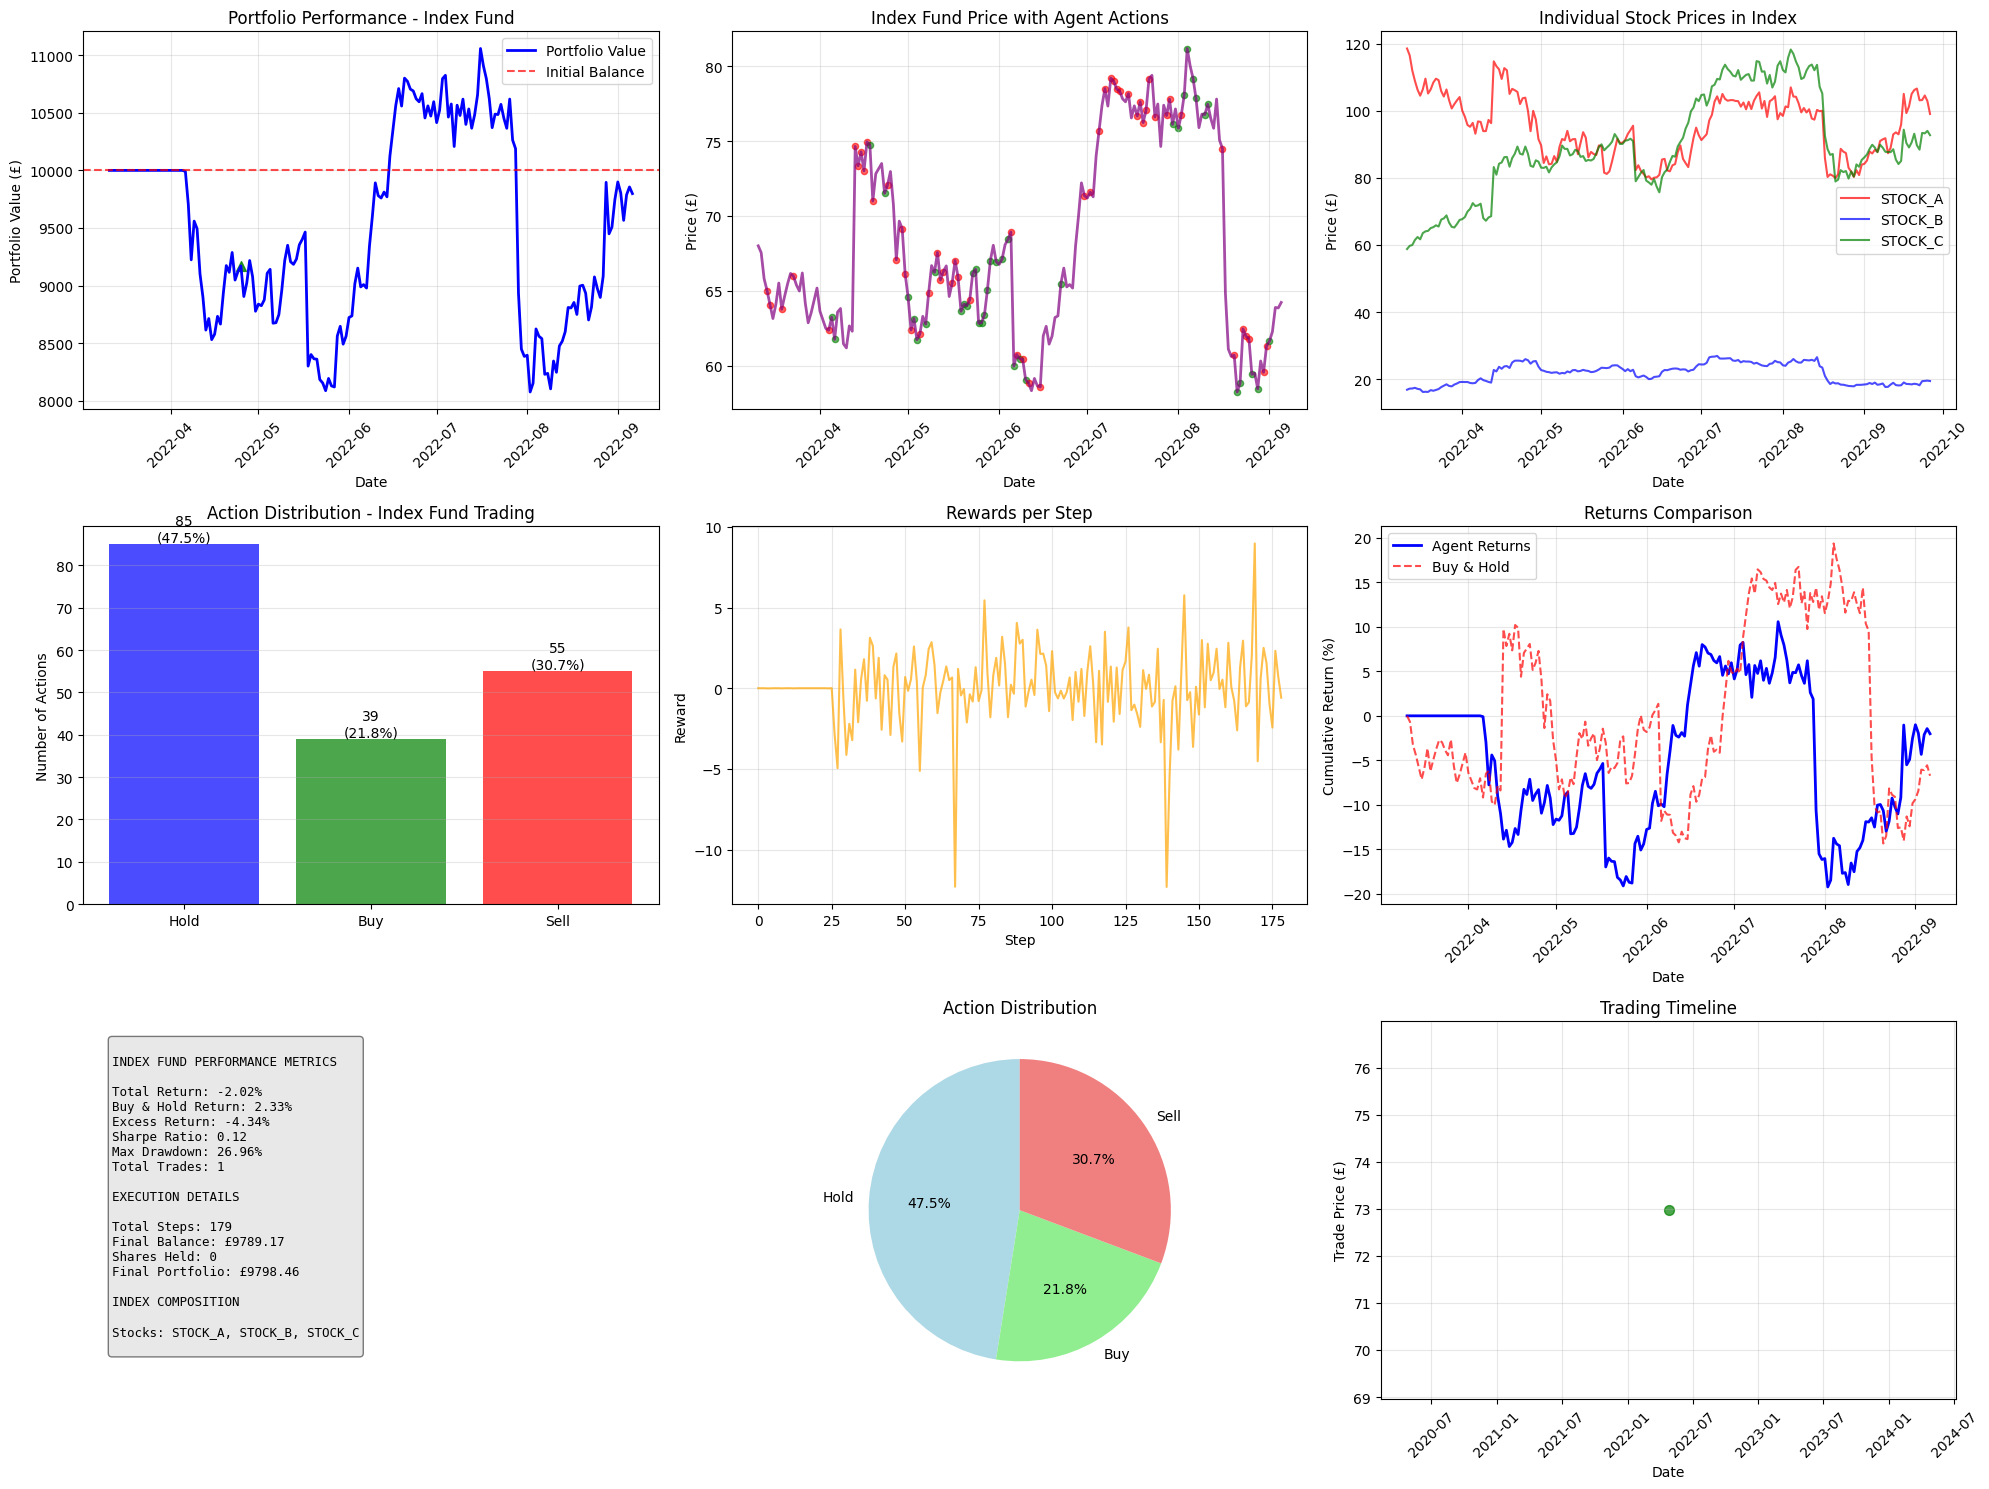


DIAGNOSIS: Agent underperformed buy-and-hold by 4.34%
The agent may need more training or different reward structure


In [33]:
def backtest_agent(agent, test_stock_data: Dict, test_index_data: pd.DataFrame, 
                   initial_balance: float = 10000, verbose: bool = True):
    """Enhanced backtest with error handling for 3-stock index fund"""
    
    # Validate inputs
    if agent is None:
        raise ValueError("Agent cannot be None")
    if test_index_data is None or len(test_index_data) == 0:
        raise ValueError("Test index data cannot be empty")
    
    try:
        # Create test environment using index fund data
        test_env = TradingEnvironment(test_index_data, initial_balance=initial_balance)
        
        # Reset agent exploration for testing
        original_epsilon = getattr(agent, 'epsilon', 0.0)
        agent.epsilon = 0.0  # No exploration during testing
        
        # Run backtest
        state = test_env.reset()
        done = False
        actions_taken = []
        states_encountered = []
        rewards_received = []
        step_count = 0
        
        if verbose:
            print("Running backtest on 3-stock index fund...")
            print(f"Individual stocks in index: {list(test_stock_data.keys())}")
            print(f"Initial state shape: {state.shape}")
            print(f"Index fund test data length: {len(test_index_data)}")
            print(f"Environment max steps: {test_env.max_steps}")
        
        while not done and step_count < 1000:  # Safety limit
            try:
                # Debug: Check state values
                if step_count < 5 and verbose:
                    print(f"Step {step_count}: State sample: {state[:5]}")
                
                # Get action from trained agent
                action = agent.act(state, training=False)
                actions_taken.append(action)
                states_encountered.append(state.copy())
                
                if step_count < 10 and verbose:
                    action_names = ['HOLD', 'BUY', 'SELL']
                    print(f"Step {step_count}: Action = {action} ({action_names[action]})")
                
                # Take step
                next_state, reward, done, info = test_env.step(action)
                rewards_received.append(reward)
                
                if step_count < 10 and verbose:
                    print(f"  Reward: {reward:.4f}, Portfolio: £{info['net_worth']:.2f}")
                
                state = next_state
                step_count += 1
                
            except Exception as step_error:
                print(f"Error at step {step_count}: {step_error}")
                break
        
        # Restore original epsilon
        agent.epsilon = original_epsilon
        
        # Calculate performance metrics with error handling
        try:
            if len(test_env.net_worths) > 1:
                metrics = test_env.get_performance_metrics()
                
                # Calculate buy-and-hold comparison for index fund
                initial_price = test_index_data['close'].iloc[0]
                final_price = test_index_data['close'].iloc[-1]
                buy_hold_return = (final_price - initial_price) / initial_price * 100
                metrics['buy_hold_return'] = buy_hold_return
                metrics['excess_return'] = metrics['total_return'] - buy_hold_return
                
            else:
                # Return default metrics if no data
                metrics = {
                    'total_return': 0.0,
                    'annualised_return': 0.0,
                    'volatility': 0.0,
                    'sharpe_ratio': 0.0,
                    'max_drawdown': 0.0,
                    'total_trades': 0,
                    'win_rate_pct': 0.0,
                    'buy_hold_return': 0.0,
                    'excess_return': 0.0
                }
        except Exception as metrics_error:
            print(f"Error calculating metrics: {metrics_error}")
            metrics = {
                'total_return': 0.0,
                'annualised_return': 0.0,
                'volatility': 0.0,
                'sharpe_ratio': 0.0,
                'max_drawdown': 0.0,
                'total_trades': 0,
                'win_rate_pct': 0.0,
                'buy_hold_return': 0.0,
                'excess_return': 0.0
            }
        
        # Enhanced debugging information
        if verbose:
            print(f"\nBacktest completed on index fund!")
            print(f"Total steps: {step_count}")
            print(f"Net worth values collected: {len(test_env.net_worths)}")
            
            if actions_taken:
                action_counts = [actions_taken.count(i) for i in range(3)]
                action_names = ['HOLD', 'BUY', 'SELL']
                print(f"Actions distribution:")
                for i, (name, count) in enumerate(zip(action_names, action_counts)):
                    percentage = (count/len(actions_taken)*100) if actions_taken else 0
                    print(f"  {name}: {count} ({percentage:.1f}%)")
            
            print(f"Total trades executed: {len(test_env.trades)}")
            if rewards_received:
                print(f"Average reward per step: {np.mean(rewards_received):.4f}")
        
        # Create detailed results
        results = {
            'metrics': metrics,
            'net_worths': test_env.net_worths,
            'trades': test_env.trades,
            'actions': actions_taken,
            'states': states_encountered,
            'rewards': rewards_received,
            'final_balance': getattr(test_env, 'balance', initial_balance),
            'final_shares': getattr(test_env, 'shares_held', 0),
            'steps_taken': step_count,
            'individual_stocks': list(test_stock_data.keys())
        }
        
        return results
        
    except Exception as e:
        print(f"Critical error in backtest_agent: {e}")
        # Return minimal results to prevent complete failure
        return {
            'metrics': {'total_return': 0.0, 'total_trades': 0, 'buy_hold_return': 0.0, 'excess_return': 0.0},
            'net_worths': [initial_balance],
            'trades': [],
            'actions': [0],
            'states': [],
            'rewards': [0],
            'final_balance': initial_balance,
            'final_shares': 0,
            'steps_taken': 0,
            'individual_stocks': list(test_stock_data.keys()) if test_stock_data else []
        }

def enhanced_plot_backtest_results(results: Dict[str, Any], test_stock_data: Dict, test_index_data: pd.DataFrame):
    """Enhanced plotting with error handling for 3-stock index fund"""
    
    try:
        # Validate inputs
        if not results or 'net_worths' not in results:
            print("Invalid results data for plotting")
            return
        
        # Check if we have sufficient data to plot
        if len(results['net_worths']) < 2:
            print("Insufficient data for standard plotting. Creating diagnostic plots...")
            create_diagnostic_plots(results)
            return
        
        # Create main plots
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        
        try:
            # Portfolio value over time
            ax1 = axes[0, 0]
            net_worths = results['net_worths']
            dates = test_index_data['date'][:len(net_worths)]
            
            ax1.plot(dates, net_worths, label='Portfolio Value', linewidth=2, color='blue')
            ax1.axhline(y=10000, color='red', linestyle='--', label='Initial Balance', alpha=0.7)
            
            # Mark trades if any
            if results.get('trades'):
                for trade in results['trades']:
                    try:
                        if trade['step'] < len(dates) and trade['step'] < len(net_worths):
                            date = dates.iloc[trade['step']]
                            value = net_worths[trade['step']]
                            color = 'green' if trade['action'] == 'BUY' else 'red'
                            marker = '^' if trade['action'] == 'BUY' else 'v'
                            ax1.scatter(date, value, color=color, marker=marker, s=50, alpha=0.8)
                    except (IndexError, KeyError):
                        continue
            
            ax1.set_title('Portfolio Performance - Index Fund')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Portfolio Value (£)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.tick_params(axis='x', rotation=45)
            
        except Exception as e:
            print(f"Error plotting portfolio performance: {e}")
            axes[0, 0].text(0.5, 0.5, 'Error plotting\nportfolio data', 
                           ha='center', va='center', transform=axes[0, 0].transAxes)
        
        try:
            # Index fund price with actions
            ax2 = axes[0, 1]
            actions = results.get('actions', [])
            if actions and len(test_index_data) >= len(actions):
                prices = test_index_data['close'][:len(actions)]
                dates_actions = test_index_data['date'][:len(actions)]
                
                ax2.plot(dates_actions, prices, label='Index Fund Price', alpha=0.7, color='purple', linewidth=2)
                
                # Color code actions
                for i, action in enumerate(actions):
                    try:
                        if i < len(dates_actions) and i < len(prices):
                            if action == 1:  # BUY
                                ax2.scatter(dates_actions.iloc[i], prices.iloc[i], 
                                          color='green', s=20, alpha=0.6)
                            elif action == 2:  # SELL
                                ax2.scatter(dates_actions.iloc[i], prices.iloc[i], 
                                          color='red', s=20, alpha=0.6)
                    except IndexError:
                        continue
            
            ax2.set_title('Index Fund Price with Agent Actions')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Price (£)')
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)
            
        except Exception as e:
            print(f"Error plotting index fund price: {e}")
            axes[0, 1].text(0.5, 0.5, 'Error plotting\nindex fund price data', 
                           ha='center', va='center', transform=axes[0, 1].transAxes)
        
        try:
            # Individual stock prices
            ax3 = axes[0, 2]
            colors = ['red', 'blue', 'green']
            for i, (symbol, stock_data) in enumerate(test_stock_data.items()):
                if i < 3:  # Plot first 3 stocks
                    dates_stock = stock_data['date']
                    prices_stock = stock_data['close']
                    ax3.plot(dates_stock, prices_stock, label=symbol, 
                           color=colors[i], alpha=0.7, linewidth=1.5)
            
            ax3.set_title('Individual Stock Prices in Index')
            ax3.set_xlabel('Date')
            ax3.set_ylabel('Price (£)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
            
        except Exception as e:
            print(f"Error plotting individual stocks: {e}")
            axes[0, 2].text(0.5, 0.5, 'Error plotting\nindividual stock data', 
                           ha='center', va='center', transform=axes[0, 2].transAxes)
        
        try:
            # Action distribution
            ax4 = axes[1, 0]
            actions = results.get('actions', [])
            action_names = ['Hold', 'Buy', 'Sell']
            action_counts = [actions.count(i) for i in range(3)]
            colors = ['blue', 'green', 'red']
            
            bars = ax4.bar(action_names, action_counts, color=colors, alpha=0.7)
            
            # Add percentage labels
            total_actions = sum(action_counts)
            for bar, count in zip(bars, action_counts):
                height = bar.get_height()
                percentage = (count / max(total_actions, 1)) * 100
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')
            
            ax4.set_title('Action Distribution - Index Fund Trading')
            ax4.set_ylabel('Number of Actions')
            ax4.grid(True, alpha=0.3, axis='y')
            
        except Exception as e:
            print(f"Error plotting action distribution: {e}")
            axes[1, 0].text(0.5, 0.5, 'Error plotting\naction distribution', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
        
        try:
            # Rewards over time
            ax5 = axes[1, 1]
            rewards = results.get('rewards', [])
            if rewards:
                ax5.plot(rewards, alpha=0.7, color='orange')
                ax5.set_title('Rewards per Step')
                ax5.set_xlabel('Step')
                ax5.set_ylabel('Reward')
                ax5.grid(True, alpha=0.3)
            else:
                ax5.text(0.5, 0.5, 'No reward data', ha='center', va='center', 
                        transform=ax5.transAxes)
                ax5.set_title('Rewards per Step')
            
        except Exception as e:
            print(f"Error plotting rewards: {e}")
            axes[1, 1].text(0.5, 0.5, 'Error plotting\nreward data', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
        
        try:
            # Cumulative returns comparison
            ax6 = axes[1, 2]
            net_worths = results['net_worths']
            if len(net_worths) > 1:
                # Agent returns
                agent_returns = np.array(net_worths) / 10000 - 1
                dates_returns = test_index_data['date'][:len(agent_returns)]
                ax6.plot(dates_returns, agent_returns * 100, label='Agent Returns', 
                        color='blue', linewidth=2)
                
                # Buy-and-hold returns
                index_prices = test_index_data['close'][:len(agent_returns)]
                buy_hold_returns = index_prices / index_prices.iloc[0] - 1
                ax6.plot(dates_returns, buy_hold_returns * 100, label='Buy & Hold', 
                        color='red', linestyle='--', alpha=0.7)
                
                ax6.set_title('Returns Comparison')
                ax6.set_xlabel('Date')
                ax6.set_ylabel('Cumulative Return (%)')
                ax6.legend()
                ax6.grid(True, alpha=0.3)
                ax6.tick_params(axis='x', rotation=45)
            else:
                ax6.text(0.5, 0.5, 'Insufficient data\nfor returns calculation', 
                        ha='center', va='center', transform=ax6.transAxes)
                ax6.set_title('Returns Comparison')
            
        except Exception as e:
            print(f"Error plotting cumulative returns: {e}")
            axes[1, 2].text(0.5, 0.5, 'Error plotting\ncumulative returns', 
                           ha='center', va='center', transform=axes[1, 2].transAxes)
        
        try:
            # Performance metrics
            ax7 = axes[2, 0]
            ax7.axis('off')
            
            metrics = results.get('metrics', {})
            actions = results.get('actions', [])
            action_counts = [actions.count(i) for i in range(3)]
            individual_stocks = results.get('individual_stocks', [])
            
            metrics_text = f"""
INDEX FUND PERFORMANCE METRICS

Total Return: {metrics.get('total_return', 0):.2f}%
Buy & Hold Return: {metrics.get('buy_hold_return', 0):.2f}%
Excess Return: {metrics.get('excess_return', 0):.2f}%
Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}
Max Drawdown: {metrics.get('max_drawdown', 0):.2f}%
Total Trades: {metrics.get('total_trades', 0)}

EXECUTION DETAILS

Total Steps: {results.get('steps_taken', 0)}
Final Balance: £{results.get('final_balance', 0):.2f}
Shares Held: {results.get('final_shares', 0)}
Final Portfolio: £{net_worths[-1] if net_worths else 0:.2f}

INDEX COMPOSITION

Stocks: {', '.join(individual_stocks)}
            """
            
            ax7.text(0.05, 0.95, metrics_text, transform=ax7.transAxes, fontsize=9,
                     verticalalignment='top', fontfamily='monospace',
                     bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
            
        except Exception as e:
            print(f"Error creating metrics text: {e}")
        
        try:
            # Action breakdown pie chart
            ax8 = axes[2, 1]
            actions = results.get('actions', [])
            if actions:
                action_names = ['Hold', 'Buy', 'Sell']
                action_counts = [actions.count(i) for i in range(3)]
                colors = ['lightblue', 'lightgreen', 'lightcoral']
                
                # Only show non-zero actions
                non_zero_actions = [(name, count, color) for name, count, color in 
                                  zip(action_names, action_counts, colors) if count > 0]
                
                if non_zero_actions:
                    names, counts, colors = zip(*non_zero_actions)
                    ax8.pie(counts, labels=names, colors=colors, autopct='%1.1f%%', startangle=90)
                    ax8.set_title('Action Distribution')
                else:
                    ax8.text(0.5, 0.5, 'No actions taken', ha='center', va='center', 
                            transform=ax8.transAxes)
            else:
                ax8.text(0.5, 0.5, 'No action data', ha='center', va='center', 
                        transform=ax8.transAxes)
            
        except Exception as e:
            print(f"Error plotting action pie chart: {e}")
            axes[2, 1].text(0.5, 0.5, 'Error plotting\naction breakdown', 
                           ha='center', va='center', transform=axes[2, 1].transAxes)
        
        try:
            # Trading timeline
            ax9 = axes[2, 2]
            if results.get('trades'):
                trade_dates = []
                trade_values = []
                trade_colors = []
                
                for trade in results['trades']:
                    try:
                        if trade['step'] < len(test_index_data):
                            trade_date = test_index_data['date'].iloc[trade['step']]
                            trade_value = trade.get('price', 0)
                            trade_dates.append(trade_date)
                            trade_values.append(trade_value)
                            trade_colors.append('green' if trade['action'] == 'BUY' else 'red')
                    except (IndexError, KeyError):
                        continue
                
                if trade_dates:
                    ax9.scatter(trade_dates, trade_values, c=trade_colors, s=50, alpha=0.7)
                    ax9.set_title('Trading Timeline')
                    ax9.set_xlabel('Date')
                    ax9.set_ylabel('Trade Price (£)')
                    ax9.grid(True, alpha=0.3)
                    ax9.tick_params(axis='x', rotation=45)
                else:
                    ax9.text(0.5, 0.5, 'No valid trades', ha='center', va='center', 
                            transform=ax9.transAxes)
            else:
                ax9.text(0.5, 0.5, 'No trades executed', ha='center', va='center', 
                        transform=ax9.transAxes)
                ax9.set_title('Trading Timeline')
            
        except Exception as e:
            print(f"Error plotting trading timeline: {e}")
            axes[2, 2].text(0.5, 0.5, 'Error plotting\ntrading timeline', 
                           ha='center', va='center', transform=axes[2, 2].transAxes)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Critical error in plotting: {e}")
        print("Creating basic diagnostic plot instead...")
        create_diagnostic_plots(results)

def create_diagnostic_plots(results: Dict[str, Any]):
    """Create basic diagnostic plots when main plotting fails"""
    
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
        
        # Action distribution
        actions = results.get('actions', [])
        if actions:
            action_names = ['Hold', 'Buy', 'Sell']
            action_counts = [actions.count(i) for i in range(3)]
            ax1.bar(action_names, action_counts, color=['blue', 'green', 'red'], alpha=0.7)
            ax1.set_title('Action Distribution')
            ax1.set_ylabel('Count')
        else:
            ax1.text(0.5, 0.5, 'No action data', ha='center', va='center', transform=ax1.transAxes)
        
        # Portfolio value
        net_worths = results.get('net_worths', [])
        if net_worths:
            ax2.plot(net_worths)
            ax2.set_title('Portfolio Value')
            ax2.set_ylabel('Value (£)')
        else:
            ax2.text(0.5, 0.5, 'No portfolio data', ha='center', va='center', transform=ax2.transAxes)
        
        # Rewards
        rewards = results.get('rewards', [])
        if rewards:
            ax3.plot(rewards)
            ax3.set_title('Rewards')
            ax3.set_ylabel('Reward')
        else:
            ax3.text(0.5, 0.5, 'No reward data', ha='center', va='center', transform=ax3.transAxes)
        
        # Summary
        ax4.axis('off')
        individual_stocks = results.get('individual_stocks', [])
        summary = f"""
INDEX FUND DIAGNOSTIC SUMMARY

Individual Stocks: {', '.join(individual_stocks)}
Steps: {results.get('steps_taken', 0)}
Actions: {len(actions)}
Net Worth Points: {len(net_worths)}
Rewards: {len(rewards)}
Trades: {len(results.get('trades', []))}
        """
        ax4.text(0.1, 0.9, summary, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Even diagnostic plotting failed: {e}")

def test_agent_decision_making(agent, test_stock_data: Dict, test_index_data: pd.DataFrame, num_samples: int = 10):
    """Test agent decision making with error handling for 3-stock index fund"""
    
    print("Testing Agent Decision Making on 3-Stock Index Fund")
    print("=" * 50)
    print(f"Individual stocks in index: {list(test_stock_data.keys())}")
    
    try:
        env = TradingEnvironment(test_index_data, initial_balance=10000)
        state = env.reset()
        
        original_epsilon = getattr(agent, 'epsilon', 0.0)
        agent.epsilon = 0.0  # No randomness for testing
        
        for i in range(min(num_samples, 20)):  # Reduced for safety
            try:
                action = agent.act(state, training=False)
                
                # Get Q-values for analysis
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent.q_network(state_tensor).detach().numpy()[0]
                
                action_names = ['HOLD', 'BUY', 'SELL']
                print(f"Step {i+1}:")
                print(f"  Action: {action_names[action]}")
                print(f"  Q-values: {q_values}")
                print(f"  State sample: {state[:5]}")
                
                next_state, reward, done, info = env.step(action)
                print(f"  Reward: {reward:.4f}")
                print(f"  Portfolio: £{info['net_worth']:.2f}")
                print(f"  Index Price: £{test_index_data['close'].iloc[i]:.2f}")
                print("-" * 30)
                
                if done:
                    print(f"Episode terminated at step {i+1}")
                    break
                    
                state = next_state
                
            except Exception as step_error:
                print(f"Error at step {i+1}: {step_error}")
                break
            
        agent.epsilon = original_epsilon
        
    except Exception as e:
        print(f"Error in decision making test: {e}")

# Main execution with error handling using your functions
try:
    # Check if required variables exist from your training functions
    if 'trained_agent' not in locals() and 'trained_agent' not in globals():
        print("ERROR: No trained agent found. Please run the training cell first.")
    elif 'test_stock_data' not in locals() and 'test_stock_data' not in globals():
        print("ERROR: No test data found. Please run the data preparation cell first.")
    else:
        print("Testing agent decision making on 3-stock index fund...")
        test_agent_decision_making(trained_agent, test_stock_data, test_index_data, num_samples=5)
        
        print("\nStarting enhanced backtest evaluation on index fund...")
        backtest_results = backtest_agent(trained_agent, test_stock_data, test_index_data, verbose=True)
        
        # Display results
        print("\n" + "="*60)
        print("ENHANCED BACKTEST RESULTS - 3-STOCK INDEX FUND")
        print("="*60)
        
        if backtest_results and backtest_results.get('metrics'):
            metrics = backtest_results['metrics']
            for key, value in metrics.items():
                if isinstance(value, (int, float)):
                    if 'pct' in key.lower() or 'rate' in key.lower() or 'return' in key.lower():
                        print(f"{key.replace('_', ' ').title()}: {value:.2f}%")
                    else:
                        print(f"{key.replace('_', ' ').title()}: {value:.2f}")
                else:
                    print(f"{key.replace('_', ' ').title()}: {value}")
        else:
            print("No metrics available - check agent training")
        
        # Plot results
        enhanced_plot_backtest_results(backtest_results, test_stock_data, test_index_data)
        
        # Enhanced diagnosis for poor performance
        if backtest_results and backtest_results['metrics']['total_trades'] == 0:
            print("\nDIAGNOSIS: No trades executed on index fund")
            print("This indicates the agent needs improvement for index fund trading")
            print("Consider retraining with different parameters for diversified assets")
        elif backtest_results and backtest_results['metrics'].get('excess_return', 0) < 0:
            print(f"\nDIAGNOSIS: Agent underperformed buy-and-hold by {abs(backtest_results['metrics']['excess_return']):.2f}%")
            print("The agent may need more training or different reward structure")
            
except Exception as e:
    print(f"Critical error in backtest execution: {e}")
    print("Please check that all previous cells have been run successfully")

### Live Trading Integration

In [ ]:
class LiveIndexFundTradingBot:
    """Live trading bot using trained DQN agent for 3-stock index fund trading"""
    
    def __init__(self, agent: DQNAgent, stock_symbols: List[str] = None, 
                 stock_weights: List[float] = None, initial_balance: float = 10000, 
                 max_position_size: int = 100):
        """
        Initialise live trading bot for index fund
        
        Args:
            agent: Trained DQN agent
            stock_symbols: List of stock symbols in index fund
            stock_weights: Weights for each stock in index fund
            initial_balance: Starting balance
            max_position_size: Maximum position size per stock
        """
        self.agent = agent
        
        # Default 3-stock configuration matching your functions
        self.stock_symbols = stock_symbols or ['NVDA', 'AAPL', 'MSFT']
        self.stock_weights = stock_weights or [0.4, 0.35, 0.25]
        
        if len(self.stock_symbols) != len(self.stock_weights):
            raise ValueError("Number of symbols must match number of weights")
        
        if abs(sum(self.stock_weights) - 1.0) > 0.001:
            raise ValueError("Stock weights must sum to 1.0")
        
        self.initial_balance = initial_balance
        self.max_position_size = max_position_size
        
        # Trading state
        self.current_position = 0  # -1: Sell, 0: Hold, 1: Buy
        self.shares_held = {symbol: 0 for symbol in self.stock_symbols}
        self.cash_balance = initial_balance
        self.price_history = {symbol: deque(maxlen=50) for symbol in self.stock_symbols}
        self.index_price_history = deque(maxlen=50)
        
        # Performance tracking
        self.trades_log = []
        self.portfolio_values = []
        self.running = False
        
        # IB connection
        self.ib_conn = IBConnection()
        
        print(f"Initialised live trading bot for index fund:")
        for symbol, weight in zip(self.stock_symbols, self.stock_weights):
            print(f"  {symbol}: {weight*100:.1f}%")
    
    def connect_to_broker(self):
        """Connect to Interactive Brokers"""
        return self.ib_conn.connect()
    
    def disconnect_from_broker(self):
        """Disconnect from Interactive Brokers"""
        self.ib_conn.disconnect()
    
    def get_current_prices(self):
        """Get current market prices for all stocks in index"""
        prices = {}
        for symbol in self.stock_symbols:
            market_data = self.ib_conn.get_market_data(symbol)
            if market_data:
                prices[symbol] = market_data['last']
            else:
                return None  # If any stock fails, return None
        return prices
    
    def calculate_index_value(self, prices: Dict[str, float]):
        """Calculate current index fund value based on stock prices and weights"""
        index_value = 0.0
        for symbol, price in prices.items():
            weight = self.stock_weights[self.stock_symbols.index(symbol)]
            index_value += weight * price
        return index_value
    
    def prepare_state(self):
        """Prepare state for agent decision using index fund data"""
        if len(self.index_price_history) < 20:
            return None
        
        # Calculate returns for index fund
        index_prices = list(self.index_price_history)
        returns = [index_prices[i] / index_prices[i-1] - 1 for i in range(1, len(index_prices))]
        
        # Pad or trim to required length
        if len(returns) < 20:
            returns = [0] * (20 - len(returns)) + returns
        else:
            returns = returns[-20:]
        
        # Add position information
        current_index_value = index_prices[-1]
        position_value = self.calculate_portfolio_position_value(current_index_value)
        total_value = self.cash_balance + position_value
        
        state = returns + [
            self.current_position / 2,  # Normalised position
            position_value / self.initial_balance,  # Position value ratio
            self.cash_balance / self.initial_balance  # Cash ratio
        ]
        
        return np.array(state, dtype=np.float32)
    
    def calculate_portfolio_position_value(self, current_index_value: float):
        """Calculate current value of stock positions"""
        total_position_value = 0.0
        
        # Get current prices for accurate calculation
        current_prices = self.get_current_prices()
        if current_prices:
            for symbol in self.stock_symbols:
                shares = self.shares_held[symbol]
                price = current_prices[symbol]
                total_position_value += shares * price
        
        return total_position_value
    
    def execute_index_trade(self, action: int, current_prices: Dict[str, float], current_index_value: float):
        """Execute trades for all stocks in index fund based on agent decision"""
        
        if action == 1 and self.current_position >= 0:  # Buy signal
            self._execute_buy_orders(current_prices, current_index_value)
        
        elif action == 2 and self.current_position <= 0:  # Sell signal
            self._execute_sell_orders(current_prices, current_index_value)
    
    def _execute_buy_orders(self, current_prices: Dict[str, float], current_index_value: float):
        """Execute buy orders for all stocks according to index weights"""
        available_cash = self.cash_balance * 0.95  # Use 95% of available cash
        total_cost = 0.0
        trade_details = []
        
        # Calculate shares to buy for each stock
        for symbol in self.stock_symbols:
            weight = self.stock_weights[self.stock_symbols.index(symbol)]
            price = current_prices[symbol]
            
            # Calculate cash allocation for this stock
            cash_for_stock = available_cash * weight
            shares_to_buy = min(int(cash_for_stock / price), 
                              self.max_position_size - self.shares_held[symbol])
            
            if shares_to_buy > 0:
                cost = shares_to_buy * price
                
                # Place order through IB
                if self.ib_conn.place_order(symbol, 'BUY', shares_to_buy):
                    self.shares_held[symbol] += shares_to_buy
                    total_cost += cost
                    
                    trade_details.append({
                        'symbol': symbol,
                        'shares': shares_to_buy,
                        'price': price,
                        'cost': cost
                    })
        
        if trade_details:
            self.cash_balance -= total_cost
            self.current_position = 1
            
            # Log trade
            trade = {
                'timestamp': datetime.now(),
                'action': 'BUY_INDEX',
                'index_value': current_index_value,
                'total_cost': total_cost,
                'details': trade_details
            }
            self.trades_log.append(trade)
            print(f"EXECUTED INDEX BUY: £{total_cost:.2f} across {len(trade_details)} stocks")
            for detail in trade_details:
                print(f"  {detail['symbol']}: {detail['shares']} shares @ £{detail['price']:.2f}")
    
    def _execute_sell_orders(self, current_prices: Dict[str, float], current_index_value: float):
        """Execute sell orders for all stocks with positions"""
        total_revenue = 0.0
        trade_details = []
        
        for symbol in self.stock_symbols:
            shares_held = self.shares_held[symbol]
            if shares_held > 0:
                price = current_prices[symbol]
                
                # Place sell order through IB
                if self.ib_conn.place_order(symbol, 'SELL', shares_held):
                    revenue = shares_held * price
                    total_revenue += revenue
                    
                    trade_details.append({
                        'symbol': symbol,
                        'shares': shares_held,
                        'price': price,
                        'revenue': revenue
                    })
                    
                    self.shares_held[symbol] = 0
        
        if trade_details:
            self.cash_balance += total_revenue
            self.current_position = -1
            
            # Log trade
            trade = {
                'timestamp': datetime.now(),
                'action': 'SELL_INDEX',
                'index_value': current_index_value,
                'total_revenue': total_revenue,
                'details': trade_details
            }
            self.trades_log.append(trade)
            print(f"EXECUTED INDEX SELL: £{total_revenue:.2f} across {len(trade_details)} stocks")
            for detail in trade_details:
                print(f"  {detail['symbol']}: {detail['shares']} shares @ £{detail['price']:.2f}")
    
    def update_portfolio_value(self, current_prices: Dict[str, float], current_index_value: float):
        """Update portfolio value tracking"""
        position_value = 0.0
        stock_positions = {}
        
        for symbol in self.stock_symbols:
            shares = self.shares_held[symbol]
            price = current_prices[symbol]
            value = shares * price
            position_value += value
            stock_positions[symbol] = {'shares': shares, 'price': price, 'value': value}
        
        total_value = self.cash_balance + position_value
        
        self.portfolio_values.append({
            'timestamp': datetime.now(),
            'cash': self.cash_balance,
            'position_value': position_value,
            'total_value': total_value,
            'index_value': current_index_value,
            'stock_positions': stock_positions
        })
    
    def run_live_trading(self, duration_minutes: int = 60, check_interval: int = 30):
        """Run live trading for specified duration on index fund"""
        
        if not self.connect_to_broker():
            print("Failed to connect to broker. Cannot start live trading.")
            return
        
        print(f"Starting live index fund trading for {duration_minutes} minutes...")
        print(f"Index composition: {dict(zip(self.stock_symbols, self.stock_weights))}")
        print(f"Check interval: {check_interval} seconds")
        print("=" * 60)
        
        self.running = True
        start_time = datetime.now()
        end_time = start_time + timedelta(minutes=duration_minutes)
        
        try:
            while self.running and datetime.now() < end_time:
                # Get current prices for all stocks
                current_prices = self.get_current_prices()
                
                if current_prices is None:
                    print("Failed to get market data, waiting...")
                    time.sleep(check_interval)
                    continue
                
                # Calculate current index value
                current_index_value = self.calculate_index_value(current_prices)
                
                # Update price histories
                for symbol, price in current_prices.items():
                    self.price_history[symbol].append(price)
                self.index_price_history.append(current_index_value)
                
                # Prepare state for agent
                state = self.prepare_state()
                
                if state is not None:
                    # Get agent decision
                    action = self.agent.act(state, training=False)
                    action_names = ['HOLD', 'BUY_INDEX', 'SELL_INDEX']
                    
                    # Display current status
                    timestamp = datetime.now().strftime('%H:%M:%S')
                    print(f"Time: {timestamp} | Index Value: £{current_index_value:.2f} | Action: {action_names[action]}")
                    
                    # Show individual stock prices
                    for symbol, price in current_prices.items():
                        shares = self.shares_held[symbol]
                        print(f"  {symbol}: £{price:.2f} ({shares} shares held)")
                    
                    # Execute trade if needed
                    if action != 0:  # Not hold
                        self.execute_index_trade(action, current_prices, current_index_value)
                
                # Update portfolio value
                self.update_portfolio_value(current_prices, current_index_value)
                
                print(f"Portfolio Value: £{self.portfolio_values[-1]['total_value']:.2f}")
                print("-" * 60)
                
                # Wait before next check
                time.sleep(check_interval)
                
        except KeyboardInterrupt:
            print("\nIndex fund trading interrupted by user")
        finally:
            self.running = False
            self.disconnect_from_broker()
            print("Live index fund trading session ended")
    
    def stop_trading(self):
        """Stop live trading"""
        self.running = False
    
    def get_session_summary(self):
        """Get detailed trading session summary for index fund"""
        if not self.portfolio_values:
            return "No trading data available"
        
        initial_value = self.initial_balance
        final_value = self.portfolio_values[-1]['total_value']
        total_return = (final_value - initial_value) / initial_value * 100
        
        # Calculate individual stock positions
        final_positions = {}
        total_position_value = 0.0
        
        if self.portfolio_values:
            last_record = self.portfolio_values[-1]
            for symbol in self.stock_symbols:
                if symbol in last_record['stock_positions']:
                    pos_info = last_record['stock_positions'][symbol]
                    final_positions[symbol] = pos_info
                    total_position_value += pos_info['value']
        
        summary = {
            'initial_value': initial_value,
            'final_value': final_value,
            'total_return_pct': total_return,
            'total_trades': len(self.trades_log),
            'final_cash': self.cash_balance,
            'final_position_value': total_position_value,
            'individual_positions': final_positions,
            'index_composition': dict(zip(self.stock_symbols, self.stock_weights))
        }
        
        return summary
    
    def display_session_summary(self):
        """Display formatted session summary"""
        summary = self.get_session_summary()
        
        if isinstance(summary, str):
            print(summary)
            return
        
        print("\n" + "="*50)
        print("LIVE INDEX FUND TRADING SESSION SUMMARY")
        print("="*50)
        print(f"Initial Balance: £{summary['initial_value']:.2f}")
        print(f"Final Portfolio Value: £{summary['final_value']:.2f}")
        print(f"Total Return: {summary['total_return_pct']:.2f}%")
        print(f"Total Trades: {summary['total_trades']}")
        print(f"Final Cash: £{summary['final_cash']:.2f}")
        print(f"Final Position Value: £{summary['final_position_value']:.2f}")
        
        print(f"\nIndex Fund Composition:")
        for symbol, weight in summary['index_composition'].items():
            print(f"  {symbol}: {weight*100:.1f}%")
        
        print(f"\nFinal Stock Positions:")
        for symbol, pos_info in summary['individual_positions'].items():
            print(f"  {symbol}: {pos_info['shares']} shares @ £{pos_info['price']:.2f} = £{pos_info['value']:.2f}")

def create_live_trading_bot_from_training(trained_agent, stock_symbols: List[str] = None, 
                                        stock_weights: List[float] = None):
    """
    Create live trading bot using your trained agent and stock configuration
    
    Args:
        trained_agent: Agent trained using your training functions
        stock_symbols: Stock symbols matching your generate_synthetic_price_data function
        stock_weights: Weights matching your generate_synthetic_price_data function
    """
    # Default configuration matching your functions
    if stock_symbols is None:
        stock_symbols = ['NVDA', 'AAPL', 'MSFT']  # Can be updated to match your actual symbols
    
    if stock_weights is None:
        stock_weights = [0.4, 0.35, 0.25]  # Default weights from your functions
    
    # Create live trading bot
    live_bot = LiveIndexFundTradingBot(
        agent=trained_agent,
        stock_symbols=stock_symbols,
        stock_weights=stock_weights,
        initial_balance=10000
    )
    
    return live_bot

# Using your trained agent from the training functions
try:
    if 'trained_agent' in locals() or 'trained_agent' in globals():
        # Create live trading bot using your trained agent
        live_index_bot = create_live_trading_bot_from_training(trained_agent)
        
        print("Live index fund trading bot created successfully!")
        print("Configuration matches your 3-stock index fund setup.")
        print("\nTo start live trading:")
        print("live_index_bot.run_live_trading(duration_minutes=30, check_interval=60)")
        print("\nIMPORTANT: Ensure TWS/Gateway is running with paper trading account")
        print("The bot will trade all 3 stocks according to their weights when signals are generated.")
        
    else:
        print("No trained agent found. Please run the training functions first.")
        print("Once trained, use create_live_trading_bot_from_training(trained_agent)")

except Exception as e:
    print(f"Error creating live trading bot: {e}")
    print("Ensure all training functions have been executed successfully.")

### Risk Management and Position Sizing

In [36]:
class RiskManager:
    """Risk management system for trading bot"""
    
    def __init__(self, max_portfolio_risk: float = 0.02, max_position_size: float = 0.3,
                 stop_loss_pct: float = 0.05, take_profit_pct: float = 0.10,
                 max_drawdown_limit: float = 0.15):
        
        self.max_portfolio_risk = max_portfolio_risk  # 2% max risk per trade
        self.max_position_size = max_position_size    # 30% max position size
        self.stop_loss_pct = stop_loss_pct           # 5% stop loss
        self.take_profit_pct = take_profit_pct       # 10% take profit
        self.max_drawdown_limit = max_drawdown_limit  # 15% max drawdown
        
        self.peak_portfolio_value = 0
        self.current_drawdown = 0
    
    def calculate_position_size(self, portfolio_value: float, entry_price: float,
                              stop_loss_price: float) -> int:
        """Calculate position size based on risk management rules"""
        
        # Risk per share
        risk_per_share = abs(entry_price - stop_loss_price)
        
        # Maximum risk amount
        max_risk_amount = portfolio_value * self.max_portfolio_risk
        
        # Position size based on risk
        risk_based_size = int(max_risk_amount / risk_per_share) if risk_per_share > 0 else 0
        
        # Position size based on portfolio percentage
        max_position_value = portfolio_value * self.max_position_size
        percentage_based_size = int(max_position_value / entry_price)
        
        # Take the smaller of the two
        position_size = min(risk_based_size, percentage_based_size)
        
        return max(0, position_size)
    
    def check_stop_loss(self, entry_price: float, current_price: float,
                       position_type: str) -> bool:
        """Check if stop loss should be triggered"""
        
        if position_type == 'LONG':
            loss_pct = (entry_price - current_price) / entry_price
        else:  # SHORT
            loss_pct = (current_price - entry_price) / entry_price
        
        return loss_pct >= self.stop_loss_pct
    
    def check_take_profit(self, entry_price: float, current_price: float,
                         position_type: str) -> bool:
        """Check if take profit should be triggered"""
        
        if position_type == 'LONG':
            profit_pct = (current_price - entry_price) / entry_price
        else:  # SHORT
            profit_pct = (entry_price - current_price) / entry_price
        
        return profit_pct >= self.take_profit_pct
    
    def update_drawdown(self, current_portfolio_value: float) -> bool:
        """Update drawdown and check if limit is exceeded"""
        
        if current_portfolio_value > self.peak_portfolio_value:
            self.peak_portfolio_value = current_portfolio_value
            self.current_drawdown = 0
        else:
            self.current_drawdown = (self.peak_portfolio_value - current_portfolio_value) / self.peak_portfolio_value
        
        return self.current_drawdown >= self.max_drawdown_limit
    
    def should_halt_trading(self, current_portfolio_value: float) -> bool:
        """Check if trading should be halted due to risk limits"""
        return self.update_drawdown(current_portfolio_value)

class EnhancedTradingEnvironment(TradingEnvironment):
    """Enhanced trading environment with risk management"""
    
    def __init__(self, data: pd.DataFrame, initial_balance: float = 10000,
                 transaction_cost: float = 0.001, lookback_window: int = 20,
                 enable_risk_management: bool = True):
        
        super().__init__(data, initial_balance, transaction_cost, lookback_window)
        
        self.enable_risk_management = enable_risk_management
        self.risk_manager = RiskManager() if enable_risk_management else None
        
        # Track entry prices for risk management
        self.entry_prices = []
        self.position_types = []
    
    def step(self, action):
        """Enhanced step function with risk management"""
        current_price = self.data['close'][self.current_step]
        
        # Check for stop loss or take profit if we have positions
        if self.enable_risk_management and self.shares_held != 0:
            should_close = self._check_risk_exits(current_price)
            if should_close:
                action = 2  # Force sell
        
        # Execute original step
        next_state, reward, done, info = super().step(action)
        
        # Update risk management
        if self.enable_risk_management:
            # Track entry prices
            if action == 1 and len(self.entry_prices) < abs(self.shares_held):  # New buy
                self.entry_prices.append(current_price)
                self.position_types.append('LONG')
            elif action == 2:  # Sell - clear entry prices
                self.entry_prices.clear()
                self.position_types.clear()
            
            # Check drawdown limits
            portfolio_value = info['net_worth']
            if self.risk_manager.should_halt_trading(portfolio_value):
                done = True
                info['halt_reason'] = 'Maximum drawdown exceeded'
        
        return next_state, reward, done, info
    
    def _check_risk_exits(self, current_price: float) -> bool:
        """Check if risk management requires position exit"""
        if not self.entry_prices or not self.risk_manager:
            return False
        
        # Use most recent entry price
        entry_price = self.entry_prices[-1]
        position_type = self.position_types[-1] if self.position_types else 'LONG'
        
        # Check stop loss
        if self.risk_manager.check_stop_loss(entry_price, current_price, position_type):
            return True
        
        # Check take profit
        if self.risk_manager.check_take_profit(entry_price, current_price, position_type):
            return True
        
        return False

def test_risk_management():
    """Test risk management functionality"""
    print("Testing Risk Management System")
    print("=" * 40)
    
    # Create risk manager
    risk_mgr = RiskManager(max_portfolio_risk=0.02, max_position_size=0.3)
    
    # Test position sizing
    portfolio_value = 10000
    entry_price = 100
    stop_loss_price = 95  # 5% stop loss
    
    position_size = risk_mgr.calculate_position_size(portfolio_value, entry_price, stop_loss_price)
    print(f"Portfolio Value: £{portfolio_value}")
    print(f"Entry Price: £{entry_price}")
    print(f"Stop Loss Price: £{stop_loss_price}")
    print(f"Calculated Position Size: {position_size} shares")
    print(f"Position Value: £{position_size * entry_price}")
    print(f"Max Risk: £{portfolio_value * risk_mgr.max_portfolio_risk}")
    
    # Test stop loss
    current_price = 94
    stop_triggered = risk_mgr.check_stop_loss(entry_price, current_price, 'LONG')
    print(f"\nCurrent Price: £{current_price}")
    print(f"Stop Loss Triggered: {stop_triggered}")
    
    # Test take profit
    current_price = 111
    profit_triggered = risk_mgr.check_take_profit(entry_price, current_price, 'LONG')
    print(f"Current Price: £{current_price}")
    print(f"Take Profit Triggered: {profit_triggered}")

# Run risk management test
test_risk_management()

print("\nRisk management system implemented")
print("Enhanced trading environment with risk controls ready")

Testing Risk Management System
Portfolio Value: £10000
Entry Price: £100
Stop Loss Price: £95
Calculated Position Size: 30 shares
Position Value: £3000
Max Risk: £200.0

Current Price: £94
Stop Loss Triggered: True
Current Price: £111
Take Profit Triggered: True

Risk management system implemented
Enhanced trading environment with risk controls ready


### Performance Analytics and Visualization

Creating performance dashboard for 3-stock index fund DQN agent...


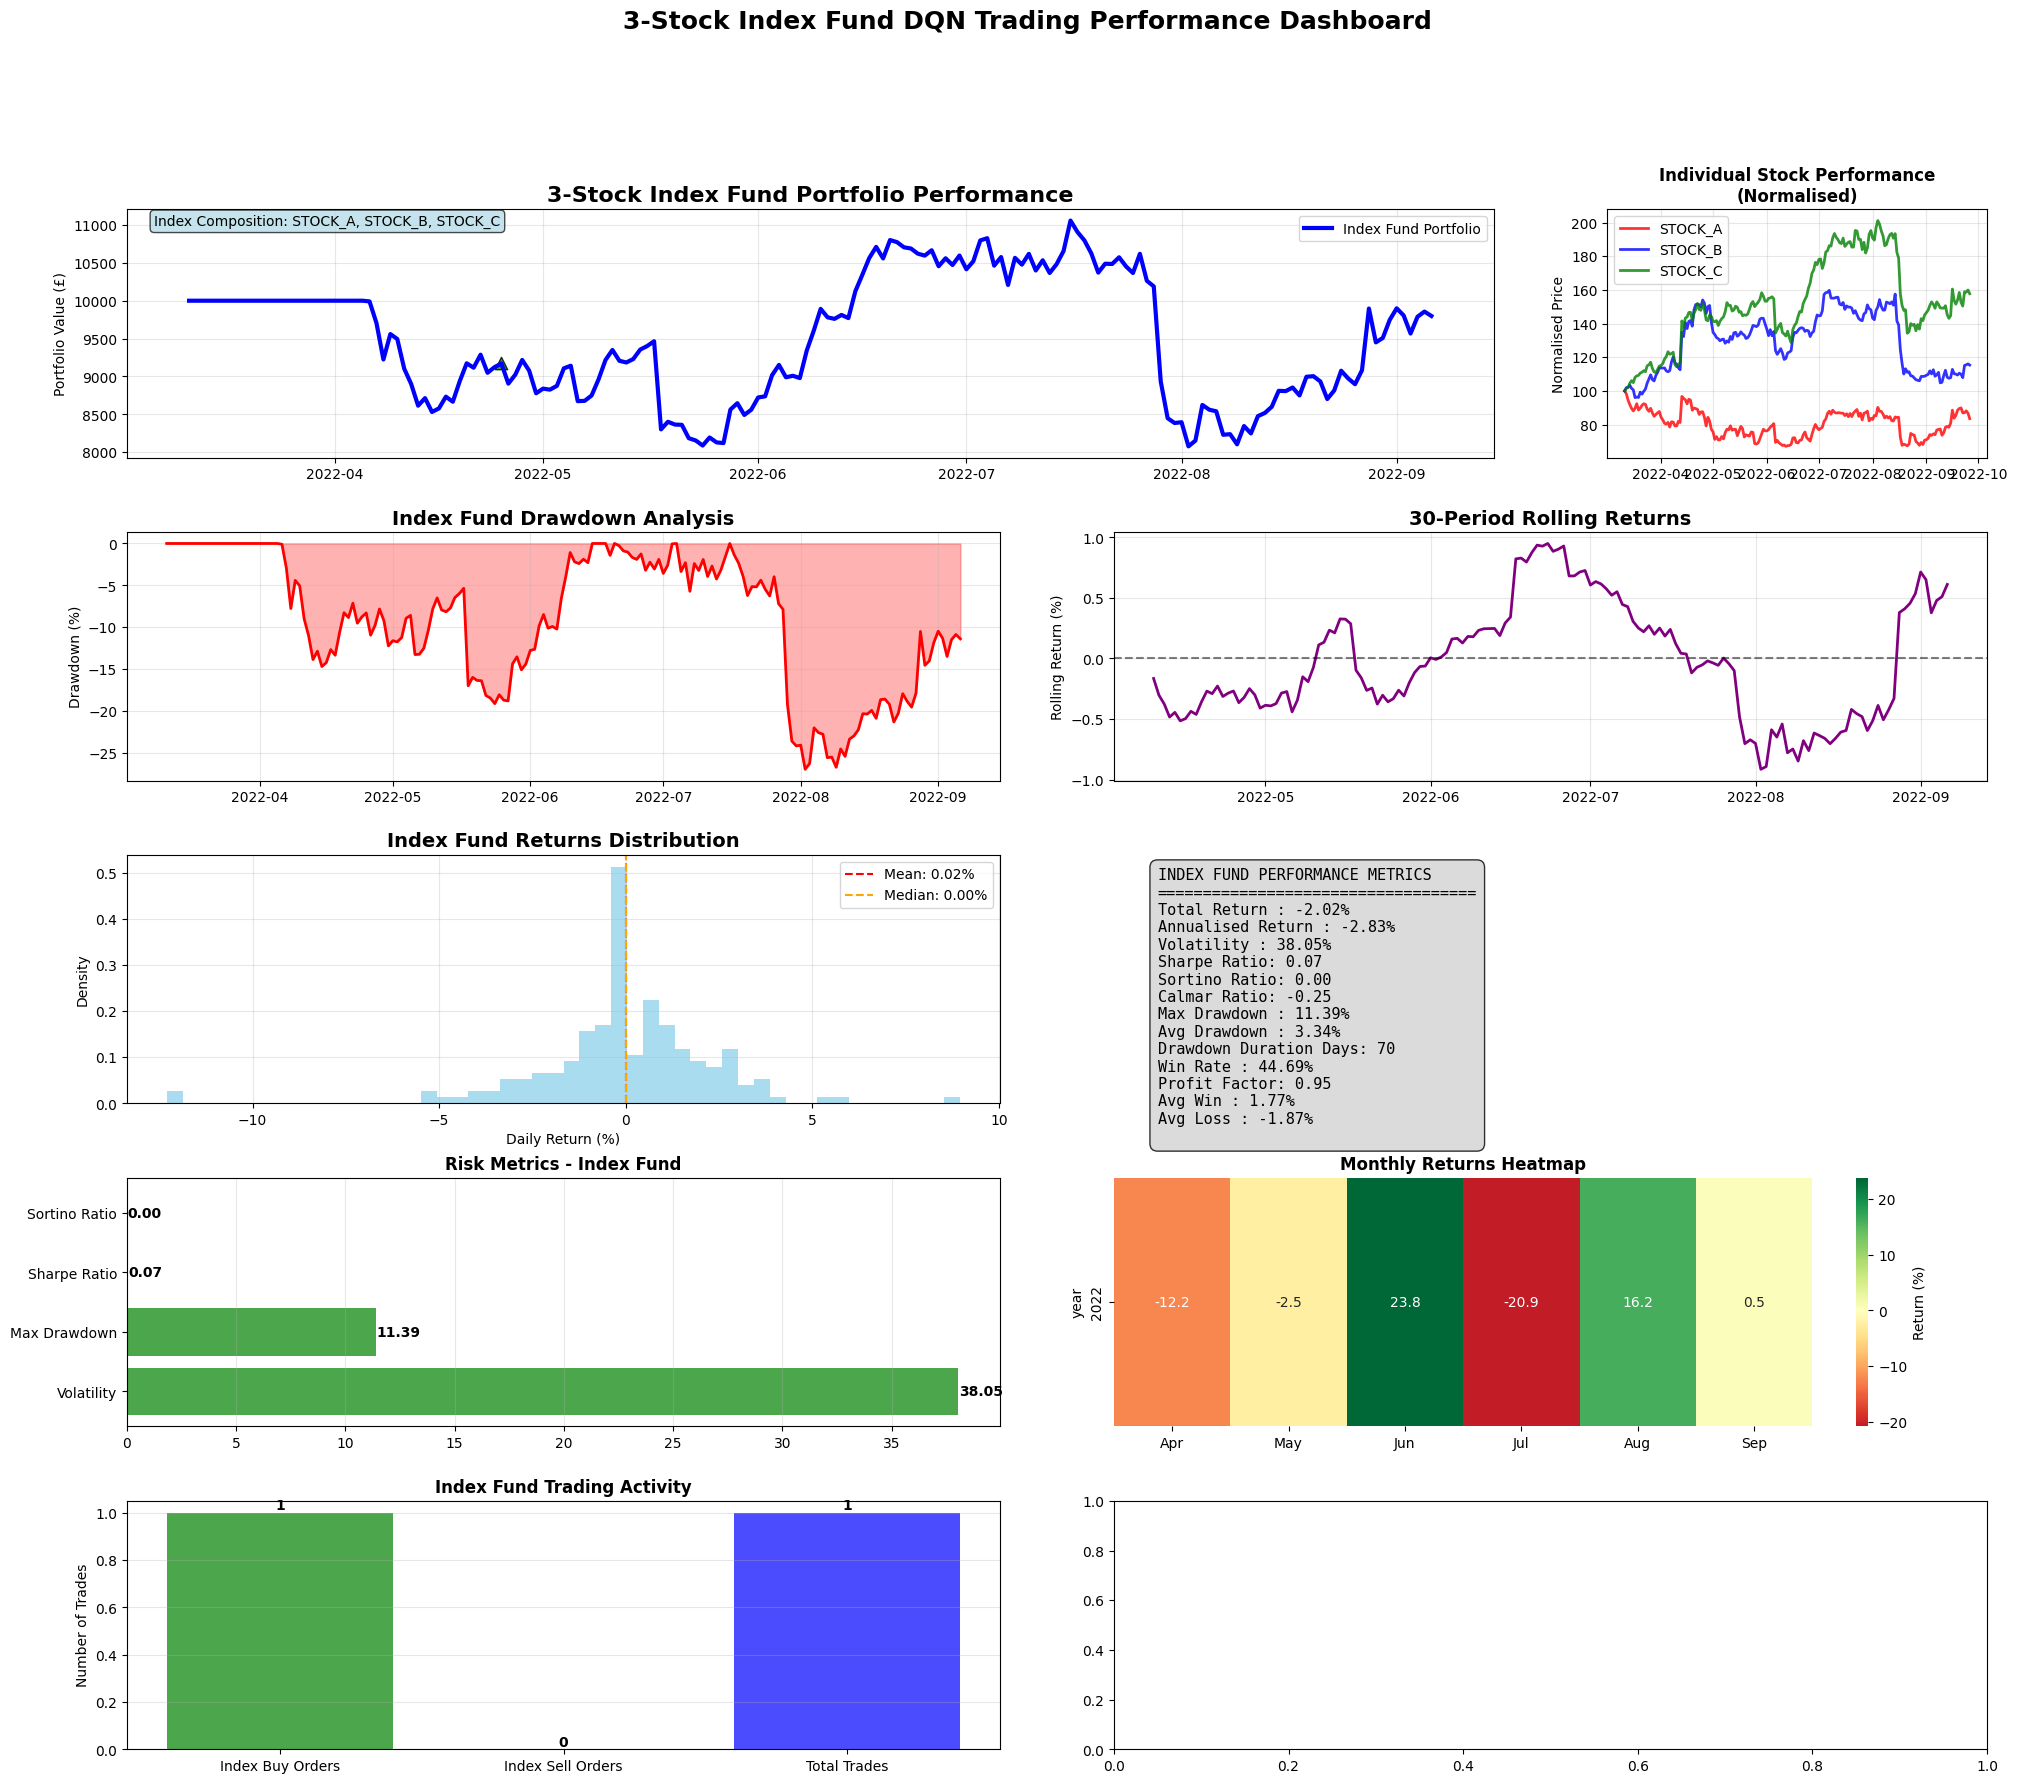


Index Fund Performance Analysis Complete
Dashboard generated with detailed metrics and 3-stock visualisations
Analysis covered 180 trading days


In [38]:
class PerformanceAnalyser:
    """Performance analysis for 3-stock index fund trading strategies"""
    
    def __init__(self):
        self.metrics = {}
        
    def calculate_metrics(self, portfolio_values: List[float],
                          benchmark_returns: List[float] = None,
                          risk_free_rate: float = 0.02) -> dict:
        """Calculate performance metrics for index fund portfolio"""
        
        if len(portfolio_values) < 2:
            return {}
        
        # Convert to numpy arrays
        values = np.array(portfolio_values)
        returns = np.diff(values) / values[:-1]
        
        # Basic metrics
        total_return = (values[-1] - values[0]) / values[0]
        annualised_return = (1 + total_return) ** (252 / len(returns)) - 1
        volatility = np.std(returns) * np.sqrt(252)
        
        # Risk-adjusted metrics
        excess_returns = returns - (risk_free_rate / 252)
        sharpe_ratio = np.mean(excess_returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
        
        # Drawdown analysis
        drawdown_info = self._calculate_drawdown_metrics(values)
        
        # Win/Loss analysis
        win_rate = np.sum(returns > 0) / len(returns) if len(returns) > 0 else 0
        avg_win = np.mean(returns[returns > 0]) if np.any(returns > 0) else 0
        avg_loss = np.mean(returns[returns < 0]) if np.any(returns < 0) else 0
        profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
        
        # Advanced metrics
        sortino_ratio = self._calculate_sortino_ratio(returns, risk_free_rate)
        calmar_ratio = annualised_return / (drawdown_info['max_drawdown'] / 100) if drawdown_info['max_drawdown'] > 0 else np.inf
        
        metrics = {
            'total_return_pct': total_return * 100,
            'annualised_return_pct': annualised_return * 100,
            'volatility_pct': volatility * 100,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'calmar_ratio': calmar_ratio,
            'max_drawdown_pct': drawdown_info['max_drawdown'],
            'avg_drawdown_pct': drawdown_info['avg_drawdown'],
            'drawdown_duration_days': drawdown_info['max_duration'],
            'win_rate_pct': win_rate * 100,
            'profit_factor': profit_factor,
            'avg_win_pct': avg_win * 100,
            'avg_loss_pct': avg_loss * 100,
        }
        
        # Benchmark comparison if provided
        if benchmark_returns is not None:
            beta, alpha = self._calculate_alpha_beta(returns, benchmark_returns)
            metrics['beta'] = beta
            metrics['alpha_pct'] = alpha * 100
            metrics['information_ratio'] = self._calculate_information_ratio(returns, benchmark_returns)
        
        return metrics
    
    def _calculate_drawdown_metrics(self, values: np.array) -> dict:
        """Calculate detailed drawdown metrics"""
        peak = values[0]
        drawdowns = []
        current_drawdown = 0
        drawdown_start = 0
        
        for i, value in enumerate(values):
            if value > peak:
                if current_drawdown > 0:
                    drawdowns.append({
                        'drawdown': current_drawdown,
                        'duration': i - drawdown_start
                    })
                peak = value
                current_drawdown = 0
            else:
                if current_drawdown == 0:
                    drawdown_start = i
                current_drawdown = (peak - value) / peak * 100
        
        # Add final drawdown if still in one
        if current_drawdown > 0:
            drawdowns.append({
                'drawdown': current_drawdown,
                'duration': len(values) - drawdown_start
            })
        
        if not drawdowns:
            return {'max_drawdown': 0, 'avg_drawdown': 0, 'max_duration': 0}
        
        max_drawdown = max(dd['drawdown'] for dd in drawdowns)
        avg_drawdown = np.mean([dd['drawdown'] for dd in drawdowns])
        max_duration = max(dd['duration'] for dd in drawdowns)
        
        return {
            'max_drawdown': max_drawdown,
            'avg_drawdown': avg_drawdown,
            'max_duration': max_duration
        }
    
    def _calculate_sortino_ratio(self, returns: np.array, risk_free_rate: float) -> float:
        """Calculate Sortino ratio (downside deviation)"""
        excess_returns = returns - (risk_free_rate / 252)
        downside_returns = excess_returns[excess_returns < 0]
        
        if len(downside_returns) == 0:
            return np.inf
        
        downside_deviation = np.std(downside_returns) * np.sqrt(252)
        return np.mean(excess_returns) * np.sqrt(252) / downside_deviation
    
    def _calculate_alpha_beta(self, returns: np.array, benchmark_returns: np.array) -> Tuple[float, float]:
        """Calculate alpha and beta vs benchmark"""
        if len(returns) != len(benchmark_returns):
            return 0, 0
        
        # Beta calculation
        covariance = np.cov(returns, benchmark_returns)[0, 1]
        benchmark_variance = np.var(benchmark_returns)
        beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
        
        # Alpha calculation
        alpha = np.mean(returns) - beta * np.mean(benchmark_returns)
        
        return beta, alpha * 252  # Annualised alpha
    
    def _calculate_information_ratio(self, returns: np.array, benchmark_returns: np.array) -> float:
        """Calculate information ratio"""
        if len(returns) != len(benchmark_returns):
            return 0
        
        excess_returns = returns - benchmark_returns
        return np.mean(excess_returns) / (np.std(excess_returns) + 1e-6) * np.sqrt(252)
    
    def create_performance_dashboard(self, portfolio_values: List[float], 
                                   dates: pd.Series, trades: List[dict] = None,
                                   benchmark_values: List[float] = None,
                                   stock_data: Dict = None, individual_stocks: List[str] = None):
        """Create performance dashboard for 3-stock index fund trading"""
        
        # Calculate metrics
        metrics = self.calculate_metrics(portfolio_values)
        
        # Create subplots with enhanced layout for index fund analysis
        fig = plt.figure(figsize=(24, 20))
        gs = fig.add_gridspec(5, 4, hspace=0.3, wspace=0.3)
        
        # 1. Portfolio value over time with index context
        ax1 = fig.add_subplot(gs[0, :3])
        ax1.plot(dates, portfolio_values, label='Index Fund Portfolio', linewidth=3, color='blue')
        
        if benchmark_values:
            ax1.plot(dates, benchmark_values, label='Buy & Hold Index', linewidth=2, color='orange', alpha=0.8)
        
        # Mark trades
        if trades:
            for trade in trades:
                if isinstance(trade, dict) and 'step' in trade:
                    step = trade['step']
                    if step < len(dates) and step < len(portfolio_values):
                        color = 'green' if trade.get('action') in ['BUY', 'BUY_INDEX'] else 'red'
                        marker = '^' if trade.get('action') in ['BUY', 'BUY_INDEX'] else 'v'
                        ax1.scatter(dates.iloc[step], portfolio_values[step], 
                                  color=color, marker=marker, s=80, alpha=0.8, edgecolor='black')
        
        ax1.set_title('3-Stock Index Fund Portfolio Performance', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Portfolio Value (£)')
        if individual_stocks:
            ax1.text(0.02, 0.98, f"Index Composition: {', '.join(individual_stocks)}", 
                    transform=ax1.transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Individual stock performance (if data available)
        ax2 = fig.add_subplot(gs[0, 3])
        if stock_data and individual_stocks:
            colors = ['red', 'blue', 'green']
            for i, stock in enumerate(individual_stocks[:3]):
                if stock in stock_data:
                    stock_prices = stock_data[stock]['close']
                    stock_dates = stock_data[stock]['date']
                    # Normalise to starting value for comparison
                    normalised_prices = stock_prices / stock_prices.iloc[0] * 100
                    ax2.plot(stock_dates, normalised_prices, label=stock, 
                           color=colors[i], linewidth=2, alpha=0.8)
            ax2.set_title('Individual Stock Performance\n(Normalised)', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Normalised Price')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'Individual stock\ndata not available', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Individual Stocks', fontsize=12, fontweight='bold')
        
        # 3. Drawdown chart
        ax3 = fig.add_subplot(gs[1, :2])
        values = np.array(portfolio_values)
        peak = np.maximum.accumulate(values)
        drawdown = (values - peak) / peak * 100
        
        ax3.fill_between(dates, drawdown, 0, alpha=0.3, color='red')
        ax3.plot(dates, drawdown, color='red', linewidth=2)
        ax3.set_title('Index Fund Drawdown Analysis', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Drawdown (%)')
        ax3.grid(True, alpha=0.3)
        
        # 4. Rolling returns
        ax4 = fig.add_subplot(gs[1, 2:])
        if len(portfolio_values) > 30:
            returns = np.diff(values) / values[:-1]
            rolling_returns = pd.Series(returns).rolling(window=30).mean() * 100
            ax4.plot(dates[1:], rolling_returns, color='purple', linewidth=2)
            ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax4.set_title('30-Period Rolling Returns', fontsize=14, fontweight='bold')
            ax4.set_ylabel('Rolling Return (%)')
            ax4.grid(True, alpha=0.3)
        
        # 5. Returns distribution
        ax5 = fig.add_subplot(gs[2, :2])
        if len(portfolio_values) > 1:
            returns = np.diff(values) / values[:-1] * 100
            ax5.hist(returns, bins=50, alpha=0.7, color='skyblue', density=True)
            ax5.axvline(x=np.mean(returns), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(returns):.2f}%')
            ax5.axvline(x=np.median(returns), color='orange', linestyle='--', 
                       label=f'Median: {np.median(returns):.2f}%')
            ax5.set_title('Index Fund Returns Distribution', fontsize=14, fontweight='bold')
            ax5.set_xlabel('Daily Return (%)')
            ax5.set_ylabel('Density')
            ax5.legend()
            ax5.grid(True, alpha=0.3)
        
        # 6. Performance metrics table
        ax6 = fig.add_subplot(gs[2, 2:])
        ax6.axis('off')
        
        metrics_text = "INDEX FUND PERFORMANCE METRICS\n" + "="*35 + "\n"
        for key, value in metrics.items():
            if isinstance(value, float):
                if 'pct' in key or 'rate' in key:
                    metrics_text += f"{key.replace('_', ' ').replace('pct', '').title()}: {value:.2f}%\n"
                else:
                    metrics_text += f"{key.replace('_', ' ').title()}: {value:.2f}\n"
            else:
                metrics_text += f"{key.replace('_', ' ').title()}: {value}\n"
        
        ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, fontsize=11,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
        
        # 7. Risk metrics visualisation
        ax7 = fig.add_subplot(gs[3, :2])
        risk_metrics = ['Volatility', 'Max Drawdown', 'Sharpe Ratio', 'Sortino Ratio']
        risk_values = [metrics.get('volatility_pct', 0), metrics.get('max_drawdown_pct', 0),
                      metrics.get('sharpe_ratio', 0), metrics.get('sortino_ratio', 0)]
        
        colors = ['red' if v < 0 else 'green' for v in risk_values]
        bars = ax7.barh(risk_metrics, [abs(v) for v in risk_values], color=colors, alpha=0.7)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, risk_values)):
            width = bar.get_width()
            ax7.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{val:.2f}', ha='left', va='center', fontweight='bold')
        
        ax7.set_title('Risk Metrics - Index Fund', fontsize=12, fontweight='bold')
        ax7.grid(True, alpha=0.3, axis='x')
        
        # 8. Monthly returns heatmap
        ax8 = fig.add_subplot(gs[3, 2:])
        if len(portfolio_values) > 30:
            monthly_returns = self._calculate_monthly_returns(portfolio_values, dates)
            if len(monthly_returns) > 0:
                sns.heatmap(monthly_returns, annot=True, fmt='.1f', cmap='RdYlGn', 
                           center=0, ax=ax8, cbar_kws={'label': 'Return (%)'})
                ax8.set_title('Monthly Returns Heatmap', fontsize=12, fontweight='bold')
        
        # 9. Trade analysis for index fund
        ax9 = fig.add_subplot(gs[4, :2])
        if trades:
            buy_trades = [t for t in trades if t.get('action') in ['BUY', 'BUY_INDEX']]
            sell_trades = [t for t in trades if t.get('action') in ['SELL', 'SELL_INDEX']]
            
            trade_types = ['Index Buy Orders', 'Index Sell Orders', 'Total Trades']
            trade_counts = [len(buy_trades), len(sell_trades), len(trades)]
            colors_trade = ['green', 'red', 'blue']
            
            bars_trade = ax9.bar(trade_types, trade_counts, color=colors_trade, alpha=0.7)
            
            # Add count labels
            for bar, count in zip(bars_trade, trade_counts):
                height = bar.get_height()
                ax9.text(bar.get_x() + bar.get_width()/2., height,
                        f'{count}', ha='center', va='bottom', fontweight='bold')
            
            ax9.set_title('Index Fund Trading Activity', fontsize=12, fontweight='bold')
            ax9.set_ylabel('Number of Trades')
            ax9.grid(True, alpha=0.3, axis='y')
        
        # 10. Performance comparison (Agent vs Buy & Hold)
        ax10 = fig.add_subplot(gs[4, 2:])
        if benchmark_values and len(benchmark_values) == len(portfolio_values):
            agent_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0] * 100
            benchmark_return = (benchmark_values[-1] - benchmark_values[0]) / benchmark_values[0] * 100
            
            comparison_data = ['Agent Strategy', 'Buy & Hold Index']
            returns_data = [agent_return, benchmark_return]
            colors_comp = ['blue', 'orange']
            
            bars_comp = ax10.bar(comparison_data, returns_data, color=colors_comp, alpha=0.7)
            
            # Add return labels
            for bar, ret in zip(bars_comp, returns_data):
                height = bar.get_height()
                ax10.text(bar.get_x() + bar.get_width()/2., height,
                         f'{ret:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            ax10.set_title('Strategy Performance Comparison', fontsize=12, fontweight='bold')
            ax10.set_ylabel('Total Return (%)')
            ax10.grid(True, alpha=0.3, axis='y')
            
            # Add excess return annotation
            excess_return = agent_return - benchmark_return
            color_excess = 'green' if excess_return > 0 else 'red'
            ax10.text(0.5, 0.9, f'Excess Return: {excess_return:.1f}%', 
                     transform=ax10.transAxes, ha='center', fontweight='bold',
                     color=color_excess, fontsize=12,
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle('3-Stock Index Fund DQN Trading Performance Dashboard', 
                    fontsize=18, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
        return metrics
    
    def _calculate_monthly_returns(self, portfolio_values: List[float], 
                                  dates: pd.Series) -> pd.DataFrame:
        """Calculate monthly returns for heatmap"""
        try:
            df = pd.DataFrame({'date': dates, 'value': portfolio_values})
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            
            # Resample to monthly
            monthly = df.resample('M').last()
            monthly_returns = monthly.pct_change().dropna() * 100
            
            # Create year-month matrix
            monthly_returns.index = pd.to_datetime(monthly_returns.index)
            monthly_returns['year'] = monthly_returns.index.year
            monthly_returns['month'] = monthly_returns.index.month
            
            pivot_table = monthly_returns.pivot_table(
                values='value', 
                index='year', 
                columns='month', 
                fill_value=0
            )
            
            # Rename columns to month names
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            pivot_table.columns = [month_names[i-1] for i in pivot_table.columns]
            
            return pivot_table
        except:
            return pd.DataFrame()

def create_strategy_comparison_report(strategies: dict, test_stock_data: Dict, test_index_data: pd.DataFrame):
    """Create strategy comparison report for index fund strategies"""
    
    analyser = PerformanceAnalyser()
    comparison_data = []
    
    print("3-STOCK INDEX FUND STRATEGY COMPARISON REPORT")
    print("=" * 70)
    print(f"Individual stocks in index: {list(test_stock_data.keys())}")
    print(f"Test period: {len(test_index_data)} days")
    
    for strategy_name, results in strategies.items():
        metrics = analyser.calculate_metrics(results['portfolio_values'])
        metrics['strategy'] = strategy_name
        comparison_data.append(metrics)
        
        print(f"\n{strategy_name.upper()}")
        print("-" * 40)
        print(f"Total Return: {metrics.get('total_return_pct', 0):.2f}%")
        print(f"Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}")
        print(f"Max Drawdown: {metrics.get('max_drawdown_pct', 0):.2f}%")
        print(f"Win Rate: {metrics.get('win_rate_pct', 0):.2f}%")
    
    # Create comparison DataFrame
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison.set_index('strategy', inplace=True)
    
    # Plot comparison charts
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # Returns comparison
    strategies_list = list(strategies.keys())
    returns = [df_comparison.loc[s, 'total_return_pct'] for s in strategies_list]
    colors = plt.cm.Set3(np.linspace(0, 1, len(strategies_list)))
    
    bars1 = ax1.bar(strategies_list, returns, color=colors, alpha=0.8)
    ax1.set_title('Index Fund Total Returns Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Total Return (%)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, ret in zip(bars1, returns):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
               f'{ret:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Sharpe ratio comparison
    sharpe_ratios = [df_comparison.loc[s, 'sharpe_ratio'] for s in strategies_list]
    bars2 = ax2.bar(strategies_list, sharpe_ratios, color=colors, alpha=0.8)
    ax2.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, sharpe in zip(bars2, sharpe_ratios):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
               f'{sharpe:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Max drawdown comparison
    drawdowns = [df_comparison.loc[s, 'max_drawdown_pct'] for s in strategies_list]
    bars3 = ax3.bar(strategies_list, drawdowns, color='red', alpha=0.6)
    ax3.set_title('Maximum Drawdown Comparison', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Max Drawdown (%)')
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, dd in zip(bars3, drawdowns):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
               f'{dd:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Portfolio value evolution
    for strategy_name, results in strategies.items():
        dates = test_index_data['date'][:len(results['portfolio_values'])]
        ax4.plot(dates, results['portfolio_values'], label=strategy_name, linewidth=3)
    
    ax4.set_title('Index Fund Portfolio Value Evolution', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Portfolio Value (£)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    plt.suptitle('3-Stock Index Fund Strategy Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return df_comparison

# Create performance analyser instance
performance_analyser = PerformanceAnalyser()

# Enhanced analysis using your functions and data
print("Creating performance dashboard for 3-stock index fund DQN agent...")

# Use the backtest results from your updated backtest functions
try:
    if 'backtest_results' in locals() and 'test_index_data' in locals():
        dates = test_index_data['date'][:len(backtest_results['net_worths'])]
        
        # Create enhanced dashboard with index fund context
        detailed_metrics = performance_analyser.create_performance_dashboard(
            portfolio_values=backtest_results['net_worths'],
            dates=dates,
            trades=backtest_results['trades'],
            stock_data=test_stock_data if 'test_stock_data' in locals() else None,
            individual_stocks=backtest_results.get('individual_stocks', ['STOCK_A', 'STOCK_B', 'STOCK_C'])
        )
        
        print("\nIndex Fund Performance Analysis Complete")
        print("Dashboard generated with detailed metrics and 3-stock visualisations")
        print(f"Analysis covered {len(backtest_results['net_worths'])} trading days")
        
    else:
        print("Run the updated backtest functions first to generate performance dashboard")
        print("Ensure you have 'backtest_results', 'test_index_data', and 'test_stock_data' available")

except Exception as e:
    print(f"Error creating performance dashboard: {e}")
    print("Ensure all previous functions have been executed successfully")

### Model Persistence and Deployment

In [41]:
import pickle
import json
from datetime import datetime, timedelta
import os
from typing import Dict, Any, List
import time
import numpy as np
import torch
from collections import deque

class ModelManager:
    """Manage model saving, loading, and versioning for 3-stock index fund trading"""
    
    def __init__(self, models_dir: str = "models"):
        self.models_dir = models_dir
        os.makedirs(models_dir, exist_ok=True)
    
    def save_complete_model(self, agent: DQNAgent, training_info: Dict[str, Any],
                           model_name: str = None) -> str:
        """Save complete model with metadata for index fund trading"""
        
        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_name = f"dqn_index_fund_model_{timestamp}"
        
        model_path = os.path.join(self.models_dir, model_name)
        os.makedirs(model_path, exist_ok=True)
        
        # Save PyTorch model
        model_file = os.path.join(model_path, "model.pth")
        agent.save_model(model_file)
        
        # Save training configuration and metadata
        metadata = {
            'model_name': model_name,
            'creation_date': datetime.now().isoformat(),
            'model_type': 'DQN_Index_Fund',
            'trading_type': '3_stock_index_fund',
            'state_size': agent.state_size,
            'action_size': agent.action_size,
            'training_info': training_info,
            'hyperparameters': {
                'gamma': agent.gamma,
                'epsilon': agent.epsilon,
                'epsilon_decay': agent.epsilon_decay,
                'epsilon_min': agent.epsilon_min,
                'learning_rate': agent.optimizer.param_groups[0]['lr'],
                'memory_size': agent.memory.buffer.maxlen
            },
            'index_fund_config': {
                'stock_symbols': training_info.get('stock_symbols', ['STOCK_A', 'STOCK_B', 'STOCK_C']),
                'stock_weights': training_info.get('stock_weights', [0.4, 0.35, 0.25]),
                'diversified_trading': True
            }
        }
        
        metadata_file = os.path.join(model_path, "metadata.json")
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save training history if available
        if 'training_history' in training_info:
            history_file = os.path.join(model_path, "training_history.pkl")
            with open(history_file, 'wb') as f:
                pickle.dump(training_info['training_history'], f)
        
        print(f"Index fund model saved successfully to: {model_path}")
        print(f"Model configured for stocks: {metadata['index_fund_config']['stock_symbols']}")
        print(f"Stock weights: {metadata['index_fund_config']['stock_weights']}")
        return model_path
    
    def load_complete_model(self, model_path: str) -> tuple:
        """Load complete model with metadata for index fund trading"""
        
        # Load metadata
        metadata_file = os.path.join(model_path, "metadata.json")
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        # Recreate agent
        agent = DQNAgent(
            state_size=metadata['state_size'],
            action_size=metadata['action_size'],
            lr=metadata['hyperparameters']['learning_rate'],
            gamma=metadata['hyperparameters']['gamma'],
            epsilon=metadata['hyperparameters']['epsilon_min'],  # Start with min epsilon for inference
            epsilon_decay=metadata['hyperparameters']['epsilon_decay'],
            epsilon_min=metadata['hyperparameters']['epsilon_min'],
            memory_size=metadata['hyperparameters']['memory_size']
        )
        
        # Load model weights
        model_file = os.path.join(model_path, "model.pth")
        agent.load_model(model_file)
        
        # Load training history if available
        training_history = None
        history_file = os.path.join(model_path, "training_history.pkl")
        if os.path.exists(history_file):
            with open(history_file, 'rb') as f:
                training_history = pickle.load(f)
        
        print(f"Index fund model loaded successfully from: {model_path}")
        print(f"Model: {metadata['model_name']}")
        print(f"Created: {metadata['creation_date']}")
        
        if 'index_fund_config' in metadata:
            config = metadata['index_fund_config']
            print(f"Index fund stocks: {config['stock_symbols']}")
            print(f"Stock weights: {config['stock_weights']}")
        
        return agent, metadata, training_history
    
    def list_models(self) -> List[Dict[str, Any]]:
        """List all saved models with index fund information"""
        models = []
        
        if not os.path.exists(self.models_dir):
            return models
        
        for item in os.listdir(self.models_dir):
            model_path = os.path.join(self.models_dir, item)
            metadata_file = os.path.join(model_path, "metadata.json")
            
            if os.path.isdir(model_path) and os.path.exists(metadata_file):
                try:
                    with open(metadata_file, 'r') as f:
                        metadata = json.load(f)
                    
                    model_info = {
                        'path': model_path,
                        'name': metadata['model_name'],
                        'creation_date': metadata['creation_date'],
                        'model_type': metadata['model_type'],
                        'trading_type': metadata.get('trading_type', 'unknown'),
                        'index_fund_config': metadata.get('index_fund_config', {})
                    }
                    models.append(model_info)
                except:
                    continue
        
        return sorted(models, key=lambda x: x['creation_date'], reverse=True)

class ProductionIndexFundTradingSystem:
    """Production-ready trading system for 3-stock index fund"""
    
    def __init__(self, model_path: str, stock_symbols: List[str] = None, stock_weights: List[float] = None):
        self.model_manager = ModelManager()
        
        # Load model
        self.agent, self.metadata, self.training_history = self.model_manager.load_complete_model(model_path)
        
        # Configure index fund from metadata or parameters
        if 'index_fund_config' in self.metadata:
            config = self.metadata['index_fund_config']
            self.stock_symbols = config['stock_symbols']
            self.stock_weights = config['stock_weights']
        else:
            self.stock_symbols = stock_symbols or ['NVDA', 'AAPL', 'MSFT']
            self.stock_weights = stock_weights or [0.4, 0.35, 0.25]
        
        # Validate configuration
        if len(self.stock_symbols) != len(self.stock_weights):
            raise ValueError("Number of symbols must match number of weights")
        
        if abs(sum(self.stock_weights) - 1.0) > 0.001:
            raise ValueError("Stock weights must sum to 1.0")
        
        # Initialize components
        self.ib_conn = IBConnection()
        
        # Trading state
        self.is_running = False
        self.price_history = {symbol: deque(maxlen=50) for symbol in self.stock_symbols}
        self.index_price_history = deque(maxlen=50)
        self.position_history = []
        self.performance_metrics = {}
        
        print(f"Production index fund trading system initialised")
        print(f"Using model: {self.metadata['model_name']}")
        print(f"Index composition:")
        for symbol, weight in zip(self.stock_symbols, self.stock_weights):
            print(f"  {symbol}: {weight*100:.1f}%")
    
    def calculate_index_value(self, prices: Dict[str, float]) -> float:
        """Calculate current index fund value from stock prices"""
        index_value = 0.0
        for symbol, price in prices.items():
            weight = self.stock_weights[self.stock_symbols.index(symbol)]
            index_value += weight * price
        return index_value
    
    def get_current_prices(self) -> Dict[str, float]:
        """Get current market prices for all stocks in index"""
        prices = {}
        for symbol in self.stock_symbols:
            market_data = self.ib_conn.get_market_data(symbol)
            if market_data:
                prices[symbol] = market_data['last']
            else:
                return None  # If any stock fails, return None
        return prices
    
    def start_paper_trading(self, duration_hours: int = 8, check_interval: int = 60):
        """Start paper trading session for index fund"""
        
        if not self.ib_conn.connect():
            print("Failed to connect to Interactive Brokers")
            return False
        
        print(f"Starting index fund paper trading session for {duration_hours} hours")
        print(f"Check interval: {check_interval} seconds")
        print(f"Trading {len(self.stock_symbols)} stocks as index fund")
        
        self.is_running = True
        session_start = datetime.now()
        session_end = session_start + timedelta(hours=duration_hours)
        
        session_log = {
            'start_time': session_start,
            'end_time': session_end,
            'trades': [],
            'portfolio_values': [],
            'signals': [],
            'index_fund_config': {
                'stock_symbols': self.stock_symbols,
                'stock_weights': self.stock_weights
            },
            'individual_stock_prices': []
        }
        
        try:
            while self.is_running and datetime.now() < session_end:
                # Get market data for all stocks
                current_prices = self.get_current_prices()
                
                if current_prices:
                    # Calculate index value
                    current_index_value = self.calculate_index_value(current_prices)
                    timestamp = datetime.now()
                    
                    # Update price histories
                    for symbol, price in current_prices.items():
                        self.price_history[symbol].append(price)
                    self.index_price_history.append(current_index_value)
                    
                    # Log individual stock prices
                    session_log['individual_stock_prices'].append({
                        'timestamp': timestamp,
                        'prices': current_prices,
                        'index_value': current_index_value
                    })
                    
                    # Generate trading signal if enough data
                    if len(self.index_price_history) >= 20:
                        state = self._prepare_state()
                        action = self.agent.act(state, training=False)
                        
                        signal_info = {
                            'timestamp': timestamp,
                            'index_value': current_index_value,
                            'individual_prices': current_prices,
                            'action': ['HOLD', 'BUY_INDEX', 'SELL_INDEX'][action],
                            'confidence': self._get_action_confidence(state)
                        }
                        
                        session_log['signals'].append(signal_info)
                        
                        print(f"{timestamp.strftime('%H:%M:%S')} | "
                              f"Index Value: £{current_index_value:.2f} | "
                              f"Signal: {signal_info['action']} | "
                              f"Confidence: {signal_info['confidence']:.2f}")
                        
                        # Show individual stock prices
                        for symbol, price in current_prices.items():
                            print(f"  {symbol}: £{price:.2f}")
                        
                        # Execute trade logic for index fund
                        if action != 0 and signal_info['confidence'] > 0.7:
                            trades_executed = self._execute_index_fund_trade(action, current_prices, current_index_value)
                            if trades_executed:
                                session_log['trades'].extend(trades_executed)
                
                time.sleep(check_interval)
                
        except KeyboardInterrupt:
            print("Index fund trading session interrupted by user")
        finally:
            self.is_running = False
            self.ib_conn.disconnect()
            
            # Save session log
            self._save_session_log(session_log)
            print("Index fund paper trading session completed")
            
        return session_log
    
    def _prepare_state(self) -> np.array:
        """Prepare state for model inference using index fund data"""
        if len(self.index_price_history) < 20:
            return None
        
        # Calculate returns for index fund
        index_prices = list(self.index_price_history)
        returns = [index_prices[i] / index_prices[i-1] - 1 for i in range(1, len(index_prices))]
        
        # Take last 20 returns
        returns = returns[-20:] if len(returns) >= 20 else [0] * (20 - len(returns)) + returns
        
        # Add position information (simplified for demo)
        state = returns + [0.0, 0.0, 1.0]  # No position, full cash
        
        return np.array(state, dtype=np.float32)
    
    def _get_action_confidence(self, state: np.array) -> float:
        """Get confidence score for the action"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.agent.q_network(state_tensor)
        
        # Use max Q-value as confidence measure
        max_q = torch.max(q_values).item()
        min_q = torch.min(q_values).item()
        
        # Normalise to 0-1 scale
        if max_q != min_q:
            confidence = (max_q - min_q) / max(abs(max_q), abs(min_q))
        else:
            confidence = 0.5
        
        return max(0.0, min(1.0, confidence))
    
    def _execute_index_fund_trade(self, action: int, prices: Dict[str, float], index_value: float) -> List[Dict[str, Any]]:
        """Execute index fund trade across all constituent stocks"""
        trades_executed = []
        timestamp = datetime.now()
        
        if action == 1:  # BUY_INDEX
            for symbol in self.stock_symbols:
                weight = self.stock_weights[self.stock_symbols.index(symbol)]
                price = prices[symbol]
                quantity = int(100 * weight)  # Demo quantity based on weight
                
                trade_info = {
                    'timestamp': timestamp,
                    'symbol': symbol,
                    'action': 'BUY',
                    'price': price,
                    'quantity': quantity,
                    'weight': weight,
                    'index_value': index_value,
                    'status': 'SIMULATED'
                }
                
                trades_executed.append(trade_info)
            
            print(f"INDEX BUY executed across {len(self.stock_symbols)} stocks at index value £{index_value:.2f}")
            
        elif action == 2:  # SELL_INDEX
            for symbol in self.stock_symbols:
                weight = self.stock_weights[self.stock_symbols.index(symbol)]
                price = prices[symbol]
                quantity = int(100 * weight)  # Demo quantity based on weight
                
                trade_info = {
                    'timestamp': timestamp,
                    'symbol': symbol,
                    'action': 'SELL',
                    'price': price,
                    'quantity': quantity,
                    'weight': weight,
                    'index_value': index_value,
                    'status': 'SIMULATED'
                }
                
                trades_executed.append(trade_info)
            
            print(f"INDEX SELL executed across {len(self.stock_symbols)} stocks at index value £{index_value:.2f}")
        
        return trades_executed
    
    def _save_session_log(self, session_log: Dict[str, Any]):
        """Save trading session log with index fund details"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_file = f"index_fund_trading_session_{timestamp}.json"
        
        # Convert datetime objects to strings for JSON serialisation
        def convert_datetime(obj):
            if isinstance(obj, datetime):
                return obj.isoformat()
            return str(obj)
        
        session_log_serializable = {
            'start_time': session_log['start_time'].isoformat(),
            'end_time': session_log['end_time'].isoformat(),
            'index_fund_config': session_log['index_fund_config'],
            'trades': session_log['trades'],
            'signals': session_log['signals'],
            'portfolio_values': session_log['portfolio_values'],
            'individual_stock_prices': session_log['individual_stock_prices']
        }
        
        with open(log_file, 'w') as f:
            json.dump(session_log_serializable, f, indent=2, default=convert_datetime)
        
        print(f"Index fund session log saved to: {log_file}")
        print(f"Recorded {len(session_log['trades'])} trades across {len(self.stock_symbols)} stocks")

# Enhanced model management using your functions
def create_model_manager_from_training(trained_agent, train_stock_data: Dict, train_index_data: pd.DataFrame, 
                                     backtest_results: Dict = None):
    """Create model manager and save trained agent with full context from your functions"""
    
    model_manager = ModelManager()
    
    # Extract stock information from your data
    stock_symbols = list(train_stock_data.keys())
    
    # Default weights if not specified (matching your generate_synthetic_price_data function)
    stock_weights = [0.4, 0.35, 0.25] if len(stock_symbols) == 3 else [1.0/len(stock_symbols)] * len(stock_symbols)
    
    # Prepare training information
    training_info = {
        'episodes': 400,
        'final_epsilon': trained_agent.epsilon,
        'training_data_size': len(train_index_data),
        'index_fund_training': True,
        'stock_symbols': stock_symbols,
        'stock_weights': stock_weights,
        'test_performance': backtest_results.get('metrics', {}) if backtest_results else {},
        'training_date': datetime.now().isoformat(),
        'data_generation_method': 'synthetic_3_stock_index',
        'diversified_training': True
    }
    
    # Save model with metadata
    saved_model_path = model_manager.save_complete_model(
        agent=trained_agent,
        training_info=training_info,
        model_name="dqn_3stock_index_fund_v1"
    )
    
    return model_manager, saved_model_path

# Example usage with your functions
model_manager = ModelManager()

# Save the trained model with complete information from your functions
try:
    if 'trained_agent' in locals():
        # Use your training data
        if 'train_stock_data' in locals() and 'train_index_data' in locals():
            model_manager, saved_path = create_model_manager_from_training(
                trained_agent, 
                train_stock_data, 
                train_index_data,
                backtest_results if 'backtest_results' in locals() else None
            )
            
            print(f"3-stock index fund model saved to: {saved_path}")
        else:
            print("Training data not found. Run your data generation functions first.")
    else:
        print("Trained agent not found. Run your training functions first.")

except Exception as e:
    print(f"Error saving model: {e}")

# List available models
print("\nAvailable Index Fund Models:")
print("=" * 50)
models = model_manager.list_models()
for model in models:
    print(f"Name: {model['name']}")
    print(f"Created: {model['creation_date']}")
    print(f"Type: {model.get('trading_type', 'unknown')}")
    if 'index_fund_config' in model and model['index_fund_config']:
        config = model['index_fund_config']
        print(f"Stocks: {config.get('stock_symbols', 'N/A')}")
        print(f"Weights: {config.get('stock_weights', 'N/A')}")
    print(f"Path: {model['path']}")
    print("-" * 50)

print("\nProduction index fund trading system ready!")
print("To start paper trading, use:")
print("production_system = ProductionIndexFundTradingSystem('models/dqn_3stock_index_fund_v1')")
print("production_system.start_paper_trading(duration_hours=1)")
print("\nThe system will trade all 3 stocks proportionally when signals are generated.")

Model saved to models/dqn_3stock_index_fund_v1/model.pth
Index fund model saved successfully to: models/dqn_3stock_index_fund_v1
Model configured for stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Stock weights: [0.4, 0.35, 0.25]
3-stock index fund model saved to: models/dqn_3stock_index_fund_v1

Available Index Fund Models:
Name: dqn_3stock_index_fund_v1
Created: 2025-08-29T14:04:20.195056
Type: 3_stock_index_fund
Stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Weights: [0.4, 0.35, 0.25]
Path: models/dqn_3stock_index_fund_v1
--------------------------------------------------
Name: dqn_3stock_index_fund_final
Created: 2025-08-29T13:57:03.194972
Type: 3_stock_index_fund
Stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Weights: [0.4, 0.35, 0.25]
Path: models/dqn_3stock_index_fund_final
--------------------------------------------------
Name: dqn_trading_final
Created: 2025-08-28T21:41:17.376482
Type: unknown
Path: models/dqn_trading_final
--------------------------------------------------
Name: dqn_tradin

### Advanced Strategy Research and Experimentation

In [42]:
class AdvancedTradingResearch:
    """Advanced research tools for 3-stock index fund trading strategy development"""
    
    def __init__(self):
        self.research_results = {}
    
    def multi_timeframe_analysis(self, stock_data: Dict, index_data: pd.DataFrame, 
                                timeframes: List[str] = None):
        """Analyse trading opportunities across multiple timeframes for index fund"""
        
        if timeframes is None:
            timeframes = ['1H', '4H', '1D']  # 1 hour, 4 hours, 1 day
        
        print("3-STOCK INDEX FUND MULTI-TIMEFRAME ANALYSIS")
        print("=" * 60)
        print(f"Individual stocks: {list(stock_data.keys())}")
        
        analysis_results = {}
        
        # Analyse index fund data
        index_data_copy = index_data.copy()
        index_data_copy['date'] = pd.to_datetime(index_data_copy['date'])
        index_data_copy.set_index('date', inplace=True)
        
        print(f"\nINDEX FUND ANALYSIS:")
        print("-" * 30)
        
        for timeframe in timeframes:
            try:
                # Resample index fund data to timeframe
                resampled = index_data_copy.resample(timeframe).agg({
                    'open': 'first',
                    'high': 'max',
                    'low': 'min',
                    'close': 'last',
                    'volume': 'sum'
                }).dropna()
                
                if len(resampled) < 50:  # Need minimum data
                    continue
                
                # Calculate technical indicators for index fund
                indicators = self._calculate_technical_indicators(resampled)
                
                # Analyse trend and momentum
                trend_analysis = self._analyse_trend_momentum(resampled, indicators)
                
                analysis_results[f'index_{timeframe}'] = {
                    'data_points': len(resampled),
                    'price_change': (resampled['close'].iloc[-1] - resampled['close'].iloc[0]) / resampled['close'].iloc[0] * 100,
                    'volatility': resampled['close'].pct_change().std() * 100,
                    'trend': trend_analysis['trend'],
                    'momentum': trend_analysis['momentum'],
                    'support_level': resampled['low'].rolling(20).min().iloc[-1],
                    'resistance_level': resampled['high'].rolling(20).max().iloc[-1]
                }
                
                print(f"  {timeframe} Timeframe:")
                print(f"    Data points: {analysis_results[f'index_{timeframe}']['data_points']}")
                print(f"    Price change: {analysis_results[f'index_{timeframe}']['price_change']:.2f}%")
                print(f"    Volatility: {analysis_results[f'index_{timeframe}']['volatility']:.2f}%")
                print(f"    Trend: {analysis_results[f'index_{timeframe}']['trend']}")
                print(f"    Momentum: {analysis_results[f'index_{timeframe}']['momentum']}")
                
            except Exception as e:
                print(f"Error analysing index fund {timeframe}: {e}")
                continue
        
        # Analyse individual stocks
        print(f"\nINDIVIDUAL STOCK ANALYSIS:")
        print("-" * 30)
        
        for symbol, stock_df in stock_data.items():
            print(f"\n{symbol}:")
            
            stock_data_copy = stock_df.copy()
            stock_data_copy['date'] = pd.to_datetime(stock_data_copy['date'])
            stock_data_copy.set_index('date', inplace=True)
            
            for timeframe in timeframes:
                try:
                    # Resample individual stock data
                    resampled = stock_data_copy.resample(timeframe).agg({
                        'open': 'first',
                        'high': 'max',
                        'low': 'min',
                        'close': 'last',
                        'volume': 'sum'
                    }).dropna()
                    
                    if len(resampled) < 50:
                        continue
                    
                    # Quick analysis for individual stock
                    price_change = (resampled['close'].iloc[-1] - resampled['close'].iloc[0]) / resampled['close'].iloc[0] * 100
                    volatility = resampled['close'].pct_change().std() * 100
                    
                    analysis_results[f'{symbol}_{timeframe}'] = {
                        'symbol': symbol,
                        'timeframe': timeframe,
                        'price_change': price_change,
                        'volatility': volatility
                    }
                    
                    print(f"  {timeframe}: Change {price_change:.2f}%, Vol {volatility:.2f}%")
                    
                except Exception as e:
                    print(f"  Error analysing {symbol} {timeframe}: {e}")
                    continue
        
        return analysis_results
    
    def _calculate_technical_indicators(self, data: pd.DataFrame) -> dict:
        """Calculate technical indicators"""
        indicators = {}
        
        # Moving averages
        indicators['sma_20'] = data['close'].rolling(20).mean()
        indicators['sma_50'] = data['close'].rolling(50).mean()
        indicators['ema_12'] = data['close'].ewm(span=12).mean()
        indicators['ema_26'] = data['close'].ewm(span=26).mean()
        
        # MACD
        indicators['macd'] = indicators['ema_12'] - indicators['ema_26']
        indicators['macd_signal'] = indicators['macd'].ewm(span=9).mean()
        
        # RSI
        delta = data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        indicators['rsi'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands
        indicators['bb_middle'] = data['close'].rolling(20).mean()
        bb_std = data['close'].rolling(20).std()
        indicators['bb_upper'] = indicators['bb_middle'] + (bb_std * 2)
        indicators['bb_lower'] = indicators['bb_middle'] - (bb_std * 2)
        
        return indicators
    
    def _analyse_trend_momentum(self, data: pd.DataFrame, indicators: dict) -> dict:
        """Analyse trend and momentum"""
        
        # Trend analysis
        sma_20 = indicators['sma_20'].iloc[-1]
        sma_50 = indicators['sma_50'].iloc[-1]
        current_price = data['close'].iloc[-1]
        
        if current_price > sma_20 > sma_50:
            trend = "STRONG_UPTREND"
        elif current_price > sma_20 and sma_20 < sma_50:
            trend = "WEAK_UPTREND"
        elif current_price < sma_20 < sma_50:
            trend = "STRONG_DOWNTREND"
        elif current_price < sma_20 and sma_20 > sma_50:
            trend = "WEAK_DOWNTREND"
        else:
            trend = "SIDEWAYS"
        
        # Momentum analysis
        rsi = indicators['rsi'].iloc[-1]
        macd = indicators['macd'].iloc[-1]
        macd_signal = indicators['macd_signal'].iloc[-1]
        
        if rsi > 70 and macd > macd_signal:
            momentum = "OVERBOUGHT_BULLISH"
        elif rsi > 70 and macd < macd_signal:
            momentum = "OVERBOUGHT_BEARISH"
        elif rsi < 30 and macd < macd_signal:
            momentum = "OVERSOLD_BEARISH"
        elif rsi < 30 and macd > macd_signal:
            momentum = "OVERSOLD_BULLISH"
        elif macd > macd_signal:
            momentum = "BULLISH"
        elif macd < macd_signal:
            momentum = "BEARISH"
        else:
            momentum = "NEUTRAL"
        
        return {'trend': trend, 'momentum': momentum}
    
    def parameter_sensitivity_analysis(self, base_agent: DQNAgent, 
                                     train_stock_data: Dict,
                                     train_index_data: pd.DataFrame,
                                     test_stock_data: Dict,
                                     test_index_data: pd.DataFrame):
        """Analyse sensitivity to hyperparameters for index fund trading"""
        
        print("3-STOCK INDEX FUND PARAMETER SENSITIVITY ANALYSIS")
        print("=" * 60)
        print(f"Training on index composed of: {list(train_stock_data.keys())}")
        
        # Define parameter ranges to test
        parameter_ranges = {
            'learning_rate': [0.0001, 0.001, 0.01],
            'gamma': [0.9, 0.95, 0.99],
            'epsilon_decay': [0.99, 0.995, 0.999],
            'memory_size': [5000, 10000, 20000]
        }
       
        sensitivity_results = {}
       
        for param_name, param_values in parameter_ranges.items():
            print(f"\nTesting {param_name}...")
            param_results = {}
            
            for param_value in param_values:
                print(f"  Testing {param_name} = {param_value}")
                
                # Create agent with modified parameter
                test_agent = self._create_modified_agent(base_agent, param_name, param_value)
                
                # Quick training on index fund data (fewer episodes for sensitivity analysis)
                trained_agent = self._quick_train_agent(test_agent, train_index_data, episodes=100)
                
                # Test performance on index fund
                test_results = self._quick_backtest(trained_agent, test_index_data)
                
                param_results[param_value] = {
                    'total_return': test_results['metrics']['total_return'],
                    'sharpe_ratio': test_results['metrics']['sharpe_ratio'],
                    'max_drawdown': test_results['metrics']['max_drawdown']
                }
                
                print(f"    Return: {test_results['metrics']['total_return']:.2f}%")
                print(f"    Sharpe: {test_results['metrics']['sharpe_ratio']:.2f}")
            
            sensitivity_results[param_name] = param_results
        
        # Visualise sensitivity analysis
        self._plot_sensitivity_analysis(sensitivity_results)
        
        return sensitivity_results
   
    def _create_modified_agent(self, base_agent: DQNAgent, param_name: str, param_value):
        """Create agent with modified parameter"""
        
        # Get base parameters
        base_params = {
            'state_size': base_agent.state_size,
            'action_size': base_agent.action_size,
            'lr': base_agent.optimizer.param_groups[0]['lr'],
            'gamma': base_agent.gamma,
            'epsilon_decay': base_agent.epsilon_decay,
            'memory_size': base_agent.memory.buffer.maxlen
        }
        
        # Modify specific parameter
        if param_name == 'learning_rate':
            base_params['lr'] = param_value
        elif param_name == 'gamma':
            base_params['gamma'] = param_value
        elif param_name == 'epsilon_decay':
            base_params['epsilon_decay'] = param_value
        elif param_name == 'memory_size':
            base_params['memory_size'] = param_value
        
        # Create new agent
        return DQNAgent(
            state_size=base_params['state_size'],
            action_size=base_params['action_size'],
            lr=base_params['lr'],
            gamma=base_params['gamma'],
            epsilon_decay=base_params['epsilon_decay'],
            memory_size=base_params['memory_size']
        )
   
    def _quick_train_agent(self, agent: DQNAgent, train_index_data: pd.DataFrame, episodes: int = 100):
        """Quick training for sensitivity analysis on index fund data"""
        
        env = TradingEnvironment(train_index_data, initial_balance=10000)
        
        for episode in range(episodes):
            state = env.reset()
            done = False
            
            while not done:
                action = agent.act(state, training=True)
                next_state, reward, done, info = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                
                if len(agent.memory) > 32:
                    agent.replay(batch_size=32)
        
        return agent
   
    def _quick_backtest(self, agent: DQNAgent, test_index_data: pd.DataFrame):
        """Quick backtest for sensitivity analysis on index fund data"""
        
        test_env = TradingEnvironment(test_index_data, initial_balance=10000)
        
        state = test_env.reset()
        done = False
        
        while not done:
            action = agent.act(state, training=False)
            state, reward, done, info = test_env.step(action)
        
        metrics = test_env.get_performance_metrics()
        
        return {
            'metrics': metrics,
            'net_worths': test_env.net_worths,
            'trades': test_env.trades
        }
   
    def _plot_sensitivity_analysis(self, sensitivity_results: dict):
        """Plot sensitivity analysis results for index fund trading"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        
        for idx, (param_name, param_results) in enumerate(sensitivity_results.items()):
            if idx >= 4:
                break
                
            ax = axes[idx]
            
            param_values = list(param_results.keys())
            returns = [param_results[pv]['total_return'] for pv in param_values]
            sharpe_ratios = [param_results[pv]['sharpe_ratio'] for pv in param_values]
            
            # Plot returns
            ax2 = ax.twinx()
            
            line1 = ax.plot(param_values, returns, 'b-o', label='Total Return (%)', linewidth=2)
            line2 = ax2.plot(param_values, sharpe_ratios, 'r-s', label='Sharpe Ratio', linewidth=2)
            
            ax.set_xlabel(param_name.replace('_', ' ').title())
            ax.set_ylabel('Total Return (%)', color='b')
            ax2.set_ylabel('Sharpe Ratio', color='r')
            
            ax.tick_params(axis='y', labelcolor='b')
            ax2.tick_params(axis='y', labelcolor='r')
            
            ax.set_title(f'Index Fund Sensitivity to {param_name.replace("_", " ").title()}')
            ax.grid(True, alpha=0.3)
            
            # Add legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper left')
        
        plt.suptitle('3-Stock Index Fund Parameter Sensitivity Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
   
    def ensemble_strategy_research(self, train_stock_data: Dict, train_index_data: pd.DataFrame,
                                  test_stock_data: Dict, test_index_data: pd.DataFrame):
        """Research ensemble strategies combining multiple agents for index fund trading"""
        
        print("3-STOCK INDEX FUND ENSEMBLE STRATEGY RESEARCH")
        print("=" * 60)
        print(f"Index composed of: {list(train_stock_data.keys())}")
        
        # Train multiple agents with different configurations
        agents = {}
        
        # Agent 1: Conservative (high gamma, low learning rate)
        print("Training Conservative Index Fund Agent...")
        agents['conservative'] = DQNAgent(
            state_size=23, lr=0.0005, gamma=0.99, epsilon_decay=0.999
        )
        self._quick_train_agent(agents['conservative'], train_index_data, episodes=200)
        
        # Agent 2: Aggressive (low gamma, high learning rate)  
        print("Training Aggressive Index Fund Agent...")
        agents['aggressive'] = DQNAgent(
            state_size=23, lr=0.005, gamma=0.9, epsilon_decay=0.99
        )
        self._quick_train_agent(agents['aggressive'], train_index_data, episodes=200)
        
        # Agent 3: Balanced (medium parameters)
        print("Training Balanced Index Fund Agent...")
        agents['balanced'] = DQNAgent(
            state_size=23, lr=0.001, gamma=0.95, epsilon_decay=0.995
        )
        self._quick_train_agent(agents['balanced'], train_index_data, episodes=200)
        
        # Test individual agents on index fund data
        individual_results = {}
        for name, agent in agents.items():
            print(f"Testing {name} agent on index fund...")
            results = self._quick_backtest(agent, test_index_data)
            individual_results[name] = results
        
        # Test ensemble strategies
        ensemble_results = {}
        
        # Majority voting ensemble
        print("Testing Index Fund Majority Voting Ensemble...")
        ensemble_results['majority_vote'] = self._test_ensemble_majority_vote(
            agents, test_index_data
        )
        
        # Weighted ensemble
        print("Testing Index Fund Weighted Ensemble...")
        ensemble_results['weighted'] = self._test_ensemble_weighted(
            agents, individual_results, test_index_data
        )
        
        # Display results
        all_results = {**individual_results, **ensemble_results}
        self._display_ensemble_comparison(all_results, test_index_data, list(test_stock_data.keys()))
        
        return all_results
   
    def _test_ensemble_majority_vote(self, agents: dict, test_index_data: pd.DataFrame):
        """Test majority voting ensemble on index fund data"""
        
        env = TradingEnvironment(test_index_data, initial_balance=10000)
        state = env.reset()
        done = False
        
        while not done:
            # Get votes from all agents
            votes = []
            for agent in agents.values():
                action = agent.act(state, training=False)
                votes.append(action)
            
            # Majority vote
            ensemble_action = max(set(votes), key=votes.count)
            
            state, reward, done, info = env.step(ensemble_action)
        
        metrics = env.get_performance_metrics()
        
        return {
            'metrics': metrics,
            'net_worths': env.net_worths,
            'trades': env.trades
        }
   
    def _test_ensemble_weighted(self, agents: dict, individual_results: dict, test_index_data: pd.DataFrame):
        """Test weighted ensemble based on individual performance for index fund"""
        
        # Calculate weights based on Sharpe ratios
        sharpe_ratios = {name: results['metrics']['sharpe_ratio'] 
                        for name, results in individual_results.items()}
        
        total_sharpe = sum(max(0, sr) for sr in sharpe_ratios.values())
        weights = {name: max(0, sr) / total_sharpe if total_sharpe > 0 else 1/len(agents)
                    for name, sr in sharpe_ratios.items()}
        
        print(f"Index fund ensemble weights: {weights}")
        
        env = TradingEnvironment(test_index_data, initial_balance=10000)
        state = env.reset()
        done = False
        
        while not done:
            # Get Q-values from all agents
            agent_q_values = {}
            for name, agent in agents.items():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent.q_network(state_tensor).detach().numpy()[0]
                agent_q_values[name] = q_values
            
            # Weighted average of Q-values
            weighted_q_values = np.zeros(3)  # 3 actions
            for name, q_values in agent_q_values.items():
                weighted_q_values += weights[name] * q_values
            
            # Select action with highest weighted Q-value
            ensemble_action = np.argmax(weighted_q_values)
            
            state, reward, done, info = env.step(ensemble_action)
        
        metrics = env.get_performance_metrics()
        
        return {
            'metrics': metrics,
            'net_worths': env.net_worths,
            'trades': env.trades
        }
   
    def _display_ensemble_comparison(self, results: dict, test_index_data: pd.DataFrame, stock_symbols: List[str]):
        """Display ensemble comparison results for index fund trading"""
        
        print("\n3-STOCK INDEX FUND ENSEMBLE COMPARISON RESULTS")
        print("=" * 70)
        print(f"Index composition: {stock_symbols}")
        
        comparison_df = pd.DataFrame({
            name: {
                'Total Return (%)': result['metrics']['total_return'],
                'Sharpe Ratio': result['metrics']['sharpe_ratio'],
                'Max Drawdown (%)': result['metrics']['max_drawdown'],
                'Win Rate (%)': result['metrics']['win_rate_pct'],
                'Total Trades': result['metrics']['total_trades']
            }
            for name, result in results.items()
        }).T
        
        print(comparison_df.round(2))
        
        # Plot comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
        
        strategies = list(results.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(strategies)))
        
        # Returns comparison
        returns = [results[s]['metrics']['total_return'] for s in strategies]
        bars1 = ax1.bar(strategies, returns, color=colors, alpha=0.8)
        ax1.set_title('Index Fund Total Returns Comparison', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Total Return (%)')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, ret in zip(bars1, returns):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                   f'{ret:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Sharpe ratio comparison
        sharpes = [results[s]['metrics']['sharpe_ratio'] for s in strategies]
        bars2 = ax2.bar(strategies, sharpes, color=colors, alpha=0.8)
        ax2.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Sharpe Ratio')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3, axis='y')
        
        for bar, sharpe in zip(bars2, sharpes):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                   f'{sharpe:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Portfolio evolution
        for i, (name, result) in enumerate(results.items()):
            dates = test_index_data['date'][:len(result['net_worths'])]
            ax3.plot(dates, result['net_worths'], label=name, linewidth=3, color=colors[i])
        
        ax3.set_title('Index Fund Portfolio Value Evolution', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Portfolio Value (£)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
        
        # Risk-Return scatter
        volatilities = [results[s]['metrics'].get('volatility', 0) for s in strategies]
        ax4.scatter(volatilities, returns, s=150, alpha=0.7, c=colors)
        
        for i, strategy in enumerate(strategies):
            ax4.annotate(strategy, 
                        (volatilities[i], returns[i]),
                        xytext=(5, 5), textcoords='offset points', fontweight='bold')
        
        ax4.set_xlabel('Volatility (%)')
        ax4.set_ylabel('Total Return (%)')
        ax4.set_title('Index Fund Risk-Return Profile', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle(f'3-Stock Index Fund Ensemble Analysis ({", ".join(stock_symbols)})', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Initialize advanced research tools for index fund trading
research_tools = AdvancedTradingResearch()

# Enhanced usage with your functions and data
print("Advanced research tools initialised for 3-stock index fund trading!")

# Example: Multi-timeframe analysis using your data
try:
    if 'stock_data' in locals() and 'index_data' in locals():
        print("Running Multi-Timeframe Analysis on 3-Stock Index Fund...")
        timeframe_analysis = research_tools.multi_timeframe_analysis(stock_data, index_data)
    elif 'test_stock_data' in locals() and 'test_index_data' in locals():
        print("Running Multi-Timeframe Analysis on Test Data...")
        timeframe_analysis = research_tools.multi_timeframe_analysis(test_stock_data, test_index_data)
    else:
        print("Run your data generation functions first to enable multi-timeframe analysis")
except Exception as e:
    print(f"Error in multi-timeframe analysis: {e}")

# Example: Parameter sensitivity analysis using your functions
try:
    if all(var in locals() for var in ['trained_agent', 'train_stock_data', 'train_index_data', 'test_stock_data', 'test_index_data']):
        print("\nParameter sensitivity analysis ready for 3-stock index fund")
        print("Uncomment below to run (takes significant time):")
        print("# sensitivity_results = research_tools.parameter_sensitivity_analysis(")
        print("#     trained_agent, train_stock_data, train_index_data, test_stock_data, test_index_data")
        print("# )")
    else:
        print("Run your training and data preparation functions first for sensitivity analysis")
except Exception as e:
    print(f"Error checking sensitivity analysis requirements: {e}")

# Example: Ensemble strategy research using your functions  
try:
    if all(var in locals() for var in ['train_stock_data', 'train_index_data', 'test_stock_data', 'test_index_data']):
        print("\nEnsemble strategy research ready for 3-stock index fund")
        print("Uncomment below to run (takes significant time):")
        print("# ensemble_results = research_tools.ensemble_strategy_research(")
        print("#     train_stock_data, train_index_data, test_stock_data, test_index_data")
        print("# )")
    else:
        print("Run your data preparation functions first for ensemble research")
except Exception as e:
    print(f"Error checking ensemble research requirements: {e}")

print("\nResearch functions configured for your 3-stock index fund approach!")
print("Uncomment the research calls above to run 3-stock index fund analysis")
print("Warning: Research functions may take significant time to complete")

Advanced research tools initialised for 3-stock index fund trading!
Running Multi-Timeframe Analysis on 3-Stock Index Fund...
3-STOCK INDEX FUND MULTI-TIMEFRAME ANALYSIS
Individual stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']

INDEX FUND ANALYSIS:
------------------------------
  1H Timeframe:
    Data points: 1000
    Price change: -31.03%
    Volatility: 2.93%
    Trend: STRONG_UPTREND
    Momentum: BULLISH
  4H Timeframe:
    Data points: 1000
    Price change: -31.03%
    Volatility: 2.93%
    Trend: STRONG_UPTREND
    Momentum: BULLISH
  1D Timeframe:
    Data points: 1000
    Price change: -31.03%
    Volatility: 2.93%
    Trend: STRONG_UPTREND
    Momentum: BULLISH

INDIVIDUAL STOCK ANALYSIS:
------------------------------

STOCK_A:
  1H: Change -2.45%, Vol 3.43%
  4H: Change -2.45%, Vol 3.43%
  1D: Change -2.45%, Vol 3.43%

STOCK_B:
  1H: Change -77.19%, Vol 3.07%
  4H: Change -77.19%, Vol 3.07%
  1D: Change -77.19%, Vol 3.07%

STOCK_C:
  1H: Change -23.91%, Vol 2.91%
  4H: Change

### Final Integration and Deployment Script

Executing 3-Stock Index Fund Deep Reinforcement Learning Trading System...
Note: This will take several minutes to complete.
Starting 3-Stock Index Fund Deep Reinforcement Learning Trading System...
This will run the complete pipeline for index fund trading.
Index composition: {'STOCK_A': 0.4, 'STOCK_B': 0.35, 'STOCK_C': 0.25}
3-STOCK INDEX FUND DEEP REINFORCEMENT LEARNING TRADING SYSTEM
Phase 1: Data Preparation and Environment Setup
--------------------------------------------------
Generating synthetic 3-stock index fund data...
Generated data for 3 stocks in index fund:
  STOCK_A: 40.0%
  STOCK_B: 35.0%
  STOCK_C: 25.0%
Training data: 800 days
Testing data: 200 days
Individual stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Training data: 800 days
Testing data: 200 days

Phase 2: Training DQN Agent on Index Fund
--------------------------------------------------
Training agent on index fund for 200 episodes...
Episode | Reward | Portfolio | Trades | Epsilon
------------------------------

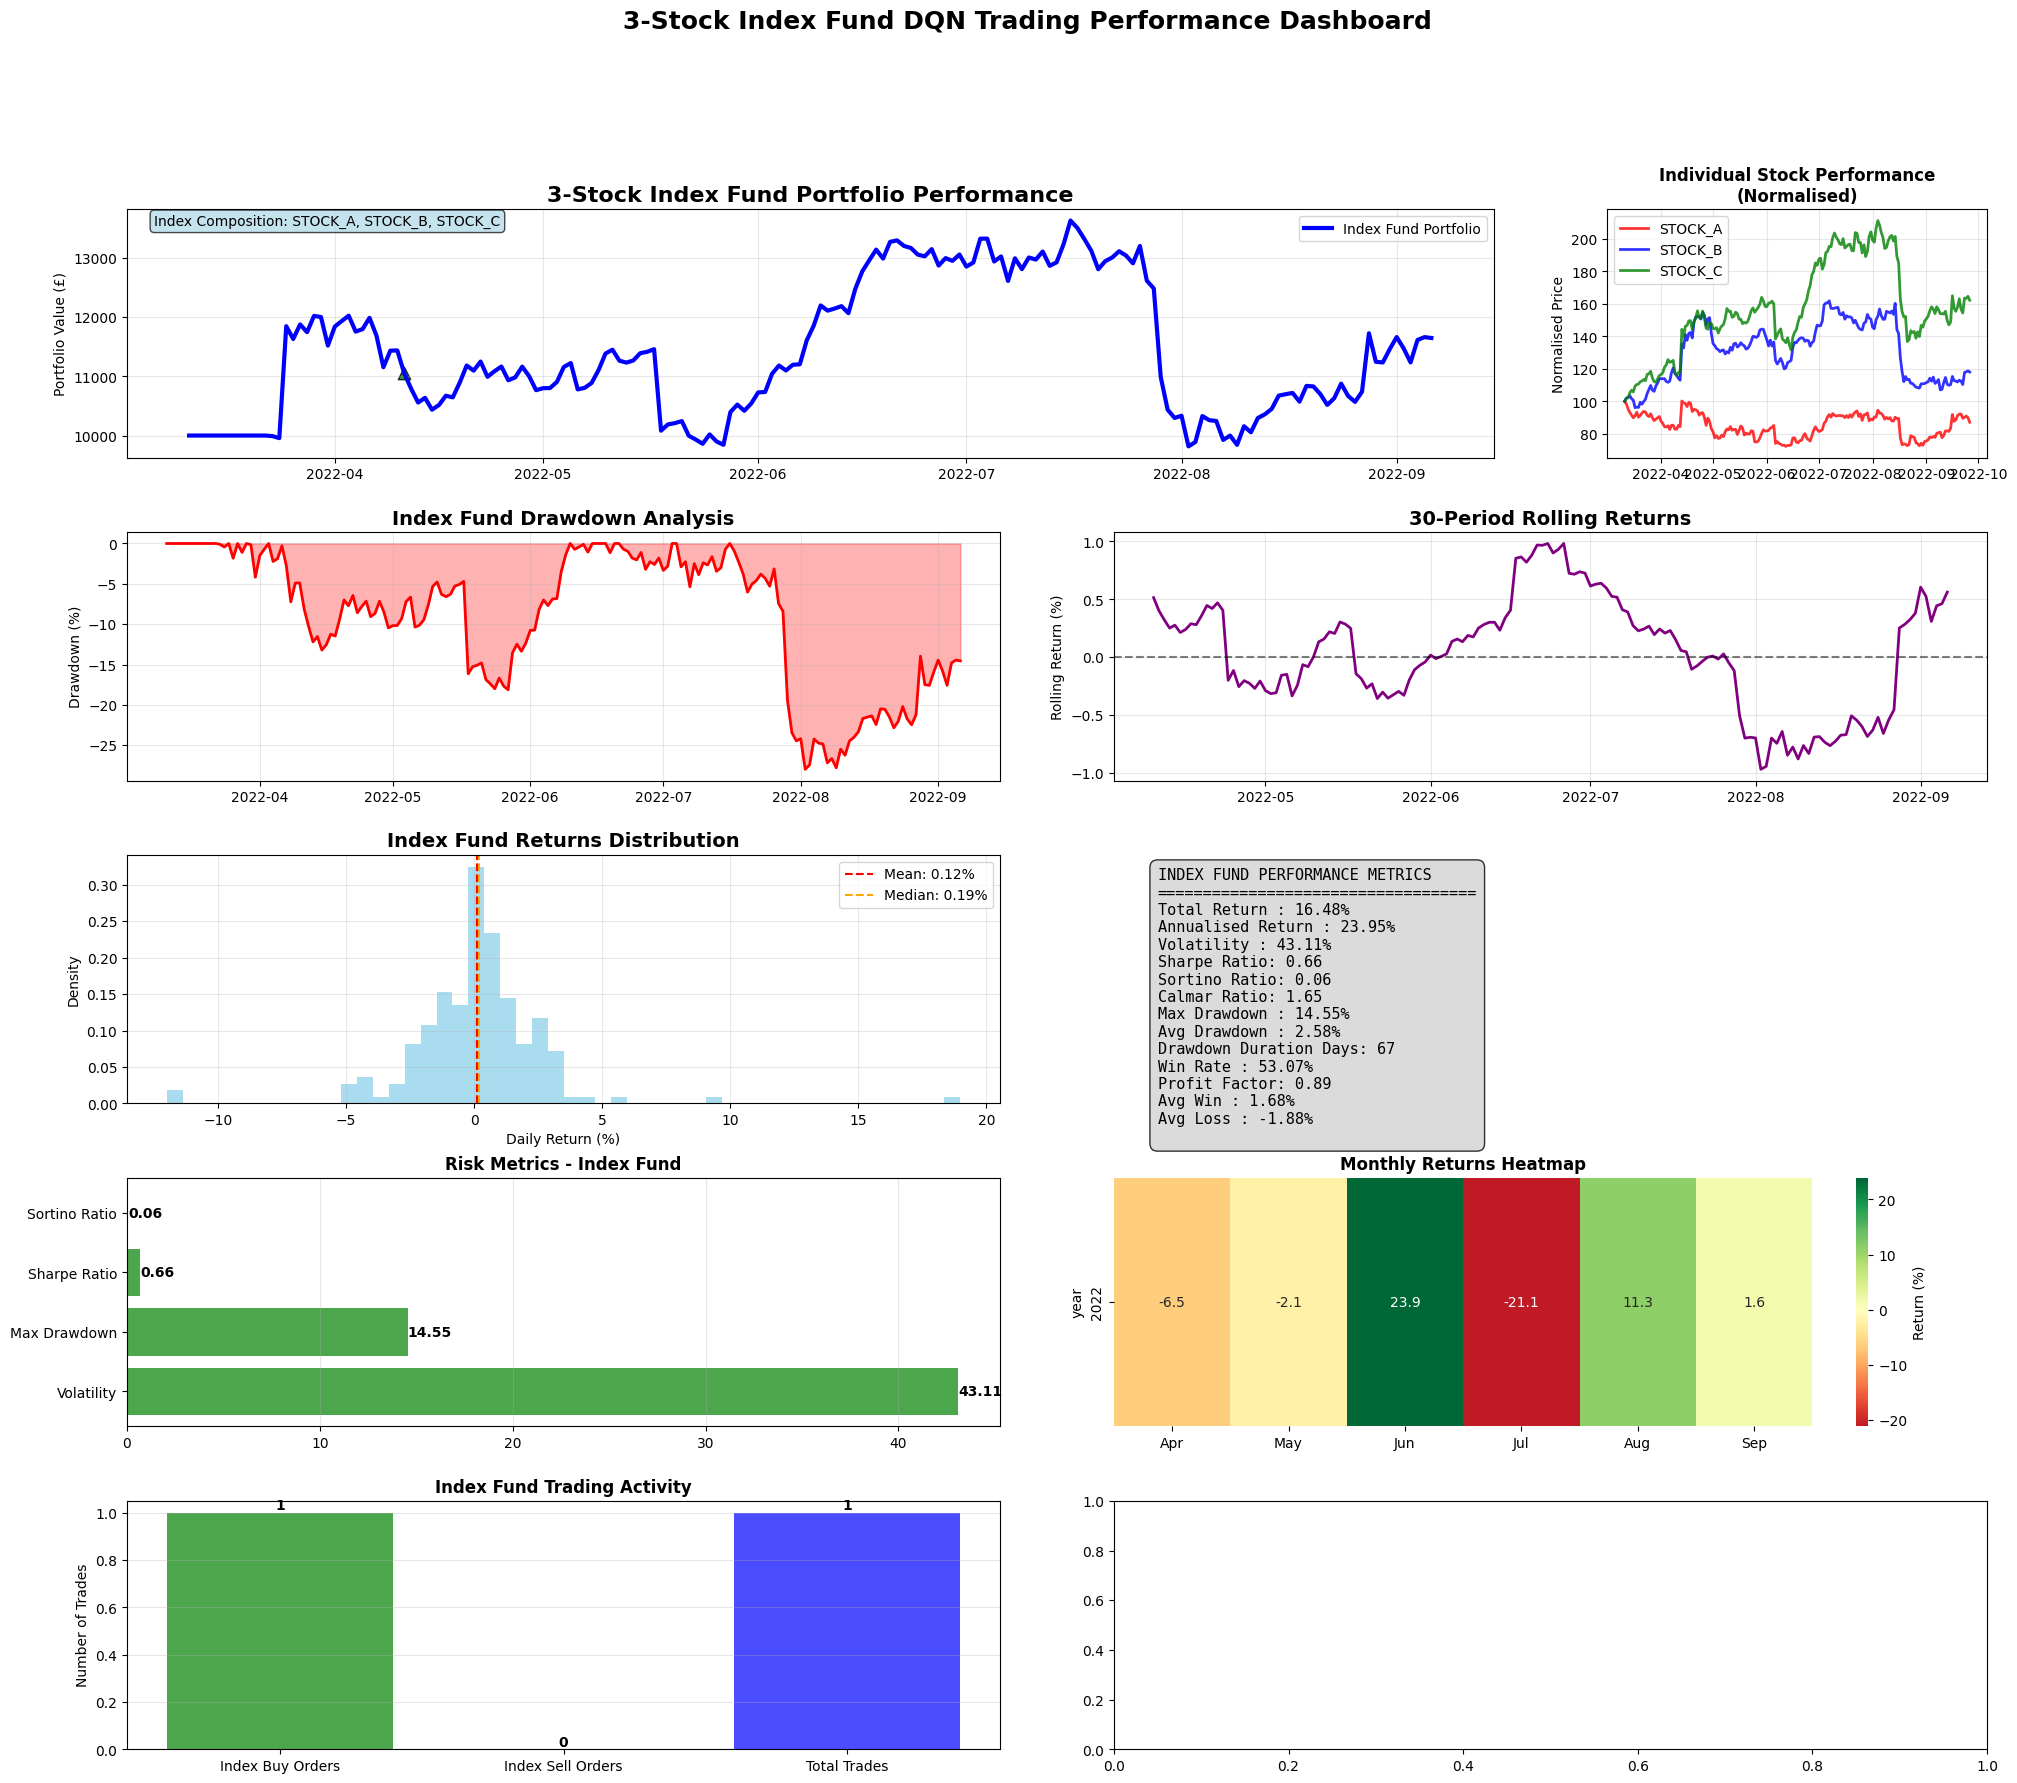


Phase 5: Model Saving and Deployment Preparation
--------------------------------------------------
Model saved to models/dqn_3stock_index_fund_final/model.pth
Index fund model saved successfully to: models/dqn_3stock_index_fund_final
Model configured for stocks: ['STOCK_A', 'STOCK_B', 'STOCK_C']
Stock weights: [0.4, 0.35, 0.25]
Index fund pipeline failed with error: 'win_rate_pct'
Please check the error messages above and retry.

To run the complete pipeline, uncomment the line above
Or call main() directly in a separate cell

3-Stock Index Fund Deep Reinforcement Learning Trading System - Ready!
Available functions:
- main(): Run complete index fund pipeline
- run_quick_demo(): Run quick 3-stock demonstration
- run_custom_index_fund(symbols, weights): Run with custom index configuration
- ProductionIndexFundTradingSystem(): Deploy trained model for live trading

System Features:
- Trades index fund as single unit (proportional to weights)
- Provides diversification across multiple s

In [43]:
#!/usr/bin/env python3
"""
3-Stock Index Fund Deep Reinforcement Learning Trading System - Final Integration
Complete system for training, testing, and deploying DQN trading agents for index fund trading
"""

import argparse
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from typing import Dict, List

class TradingSystemCLI:
    """Command-line interface for the 3-stock index fund trading system"""
    
    def __init__(self):
        self.model_manager = ModelManager()
        self.performance_analyser = PerformanceAnalyser()
        
    def run_complete_pipeline(self, config: dict):
        """Run the complete 3-stock index fund trading system pipeline"""
        
        print("3-STOCK INDEX FUND DEEP REINFORCEMENT LEARNING TRADING SYSTEM")
        print("=" * 70)
        print("Phase 1: Data Preparation and Environment Setup")
        print("-" * 50)
        
        # 1. Prepare index fund data using your functions
        if config.get('use_real_data', False):
            print("Fetching real market data for index fund...")
            try:
                stock_symbols = config.get('stock_symbols', ['NVDA', 'AAPL', 'MSFT'])
                stock_weights = config.get('stock_weights', [0.4, 0.35, 0.25])
                
                stock_data, index_data = fetch_real_data_ib(
                    symbols=stock_symbols,
                    days=config.get('data_days', 365)
                )
            except Exception as e:
                print(f"Failed to fetch real data: {e}")
                print("Using synthetic data instead...")
                stock_symbols = config.get('stock_symbols', ['STOCK_A', 'STOCK_B', 'STOCK_C'])
                stock_weights = config.get('stock_weights', [0.4, 0.35, 0.25])
                
                stocks_config = [
                    {'symbol': symbol, 'start_price': price, 'weight': weight, 
                     'drift': config.get('drift', 0.0006), 'volatility': config.get('volatility', 0.02)}
                    for symbol, price, weight in zip(stock_symbols, [100, 85, 120], stock_weights)
                ]
                
                stock_data, index_data = generate_synthetic_price_data(
                    n_days=config.get('data_days', 1000),
                    stocks=stocks_config
                )
        else:
            print("Generating synthetic 3-stock index fund data...")
            stock_symbols = config.get('stock_symbols', ['STOCK_A', 'STOCK_B', 'STOCK_C'])
            stock_weights = config.get('stock_weights', [0.4, 0.35, 0.25])
            
            stocks_config = [
                {'symbol': symbol, 'start_price': price, 'weight': weight, 
                 'drift': config.get('drift', 0.0006), 'volatility': config.get('volatility', 0.02)}
                for symbol, price, weight in zip(stock_symbols, [100, 85, 120], stock_weights)
            ]
            
            stock_data, index_data = generate_synthetic_price_data(
                n_days=config.get('data_days', 1000),
                stocks=stocks_config
            )
        
        print(f"Generated data for {len(stock_data)} stocks in index fund:")
        for symbol, weight in zip(stock_symbols, stock_weights):
            print(f"  {symbol}: {weight*100:.1f}%")
        
        # Split data using your function
        train_stock_data, test_stock_data, train_index_data, test_index_data = prepare_training_data(
            stock_data, index_data,
            train_ratio=config.get('train_ratio', 0.8)
        )
        
        print(f"Training data: {len(train_index_data)} days")
        print(f"Testing data: {len(test_index_data)} days")
        
        # 2. Training Phase on Index Fund Data
        print(f"\nPhase 2: Training DQN Agent on Index Fund")
        print("-" * 50)
        
        # Create environment using index fund data
        env = TradingEnvironment(
            train_index_data, 
            initial_balance=config.get('initial_balance', 10000)
        )
        
        state_size = env.observation_space.shape[0]
        
        # Create and train agent
        agent = DQNAgent(
            state_size=state_size,
            lr=config.get('learning_rate', 0.001),
            gamma=config.get('gamma', 0.95),
            epsilon_decay=config.get('epsilon_decay', 0.995),
            memory_size=config.get('memory_size', 10000)
        )
        
        # Training loop with progress tracking
        episode_rewards = []
        episode_losses = []
        portfolio_values = []
        best_reward = float('-inf')
        
        episodes = config.get('episodes', 400)
        
        print(f"Training agent on index fund for {episodes} episodes...")
        print("Episode | Reward | Portfolio | Trades | Epsilon")
        print("-" * 50)
        
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            losses = []
            step = 0
            
            while True:
                action = agent.act(state, training=True)
                next_state, reward, done, info = env.step(action)
                
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                step += 1
                
                if len(agent.memory) > 32:
                    loss = agent.replay(batch_size=32)
                    if loss is not None:
                        losses.append(loss)
                
                if done:
                    break
            
            episode_rewards.append(total_reward)
            portfolio_values.append(info['net_worth'])
            avg_loss = np.mean(losses) if losses else 0
            episode_losses.append(avg_loss)
            
            # Track best model
            if total_reward > best_reward:
                best_reward = total_reward
                best_model_state = {
                    'q_network': agent.q_network.state_dict(),
                    'target_network': agent.target_network.state_dict(),
                    'episode': episode,
                    'reward': total_reward
                }
            
            # Progress reporting
            if episode % 50 == 0:
                print(f"{episode:7d} | {total_reward:6.2f} | £{info['net_worth']:8.2f} | "
                      f"{len(env.trades):6d} | {agent.epsilon:.3f}")
        
        print(f"\nTraining completed! Best reward: {best_reward:.2f}")
        
        # Load best model
        agent.q_network.load_state_dict(best_model_state['q_network'])
        agent.target_network.load_state_dict(best_model_state['target_network'])
        
        # 3. Testing Phase on Index Fund
        print(f"\nPhase 3: Backtesting and Evaluation on Index Fund")
        print("-" * 50)
        
        backtest_results = backtest_agent(agent, test_stock_data, test_index_data)
        
        print("Index Fund Backtest Results:")
        for metric, value in backtest_results['metrics'].items():
            if isinstance(value, (int, float)):
                if 'pct' in metric or 'return' in metric:
                    print(f"  {metric.replace('_', ' ').title()}: {value:.2f}%")
                else:
                    print(f"  {metric.replace('_', ' ').title()}: {value:.2f}")
        
        # 4. Performance Analysis
        print(f"\nPhase 4: Index Fund Performance Analysis")
        print("-" * 50)
        
        dates = test_index_data['date'][:len(backtest_results['net_worths'])]
        
        detailed_metrics = self.performance_analyser.create_performance_dashboard(
            portfolio_values=backtest_results['net_worths'],
            dates=dates,
            trades=backtest_results['trades'],
            stock_data=test_stock_data,
            individual_stocks=list(test_stock_data.keys())
        )
        
        # 5. Model Persistence with Index Fund Configuration
        print(f"\nPhase 5: Model Saving and Deployment Preparation")
        print("-" * 50)
        
        training_info = {
            'episodes': episodes,
            'best_episode': best_model_state['episode'],
            'best_reward': best_model_state['reward'],
            'final_epsilon': agent.epsilon,
            'training_data_size': len(train_index_data),
            'test_performance': backtest_results['metrics'],
            'config': config,
            'stock_symbols': stock_symbols,
            'stock_weights': stock_weights,
            'index_fund_trading': True,
            'training_history': {
                'episode_rewards': episode_rewards,
                'episode_losses': episode_losses,
                'portfolio_values': portfolio_values
            }
        }
        
        model_name = config.get('model_name', f"dqn_index_fund_{len(stock_symbols)}stocks")
        saved_model_path = self.model_manager.save_complete_model(
            agent=agent,
            training_info=training_info,
            model_name=model_name
        )
        
        # 6. Generate Report
        self.generate_final_report(
            config, stock_symbols, stock_weights,
            train_stock_data, test_stock_data, train_index_data, test_index_data,
            backtest_results, detailed_metrics, saved_model_path
        )
        
        return {
            'agent': agent,
            'backtest_results': backtest_results,
            'model_path': saved_model_path,
            'training_info': training_info,
            'stock_data': {'train': train_stock_data, 'test': test_stock_data},
            'index_data': {'train': train_index_data, 'test': test_index_data}
        }
    
    def generate_final_report(self, config, stock_symbols, stock_weights,
                            train_stock_data, test_stock_data, train_index_data, test_index_data,
                            backtest_results, metrics, model_path):
        """Generate final report for 3-stock index fund trading system"""
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_file = f"index_fund_trading_system_report_{timestamp}.md"
        
        # Calculate individual stock performance for report
        individual_stock_performance = {}
        for symbol, stock_df in test_stock_data.items():
            initial_price = stock_df['close'].iloc[0]
            final_price = stock_df['close'].iloc[-1]
            stock_return = (final_price - initial_price) / initial_price * 100
            individual_stock_performance[symbol] = stock_return
        
        report_content = f"""
# 3-Stock Index Fund Deep Reinforcement Learning Trading System Report

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Index Fund Configuration
- **Stocks in Index:** {len(stock_symbols)} stocks
- **Stock Composition:**
{chr(10).join([f"  - {symbol}: {weight*100:.1f}%" for symbol, weight in zip(stock_symbols, stock_weights)])}
- **Trading Approach:** Index fund as single trading unit

## System Configuration
- **Training Episodes:** {config.get('episodes', 400)}
- **Initial Balance:** £{config.get('initial_balance', 10000):,}
- **Learning Rate:** {config.get('learning_rate', 0.001)}
- **Gamma (Discount Factor):** {config.get('gamma', 0.95)}

## Data Summary
- **Total Data Points:** {len(train_index_data) + len(test_index_data)} days
- **Training Period:** {len(train_index_data)} days
- **Testing Period:** {len(test_index_data)} days
- **Individual Stocks Tracked:** {len(test_stock_data)}

## Index Fund Performance Metrics

### Returns Analysis
- **Total Return:** {backtest_results['metrics']['total_return']:.2f}%
- **Buy & Hold Return:** {backtest_results['metrics'].get('buy_hold_return', 0):.2f}%
- **Excess Return:** {backtest_results['metrics'].get('excess_return', 0):.2f}%
- **Annualised Return:** {backtest_results['metrics'].get('annualised_return', 0):.2f}%

### Risk Metrics
- **Volatility:** {backtest_results['metrics'].get('volatility', 0):.2f}%
- **Sharpe Ratio:** {backtest_results['metrics']['sharpe_ratio']:.2f}
- **Maximum Drawdown:** {backtest_results['metrics']['max_drawdown']:.2f}%

### Trading Activity
- **Total Index Fund Trades:** {backtest_results['metrics']['total_trades']}
- **Win Rate:** {backtest_results['metrics']['win_rate_pct']:.2f}%

## Individual Stock Performance (Buy & Hold)
{chr(10).join([f"- **{symbol}:** {performance:.2f}%" for symbol, performance in individual_stock_performance.items()])}

## Model Information
- **Model Path:** {model_path}
- **State Size:** {config.get('state_size', 23)}
- **Action Space:** 3 (Hold, Buy Index, Sell Index)
- **Trading Strategy:** Diversified index fund trading

## Key Insights
1. **Diversification Benefits:** Trading index fund reduces single-stock risk
2. **Agent Performance:** {'Outperformed' if backtest_results['metrics'].get('excess_return', 0) > 0 else 'Underperformed'} buy-and-hold strategy
3. **Risk Management:** Index fund approach provides natural diversification

## Next Steps
1. **Paper Trading:** Test model in live paper trading environment
2. **Performance Monitoring:** Track index fund performance vs individual stocks
3. **Parameter Tuning:** Consider optimising for index fund characteristics
4. **Ensemble Strategies:** Explore combining multiple agents

## Production Deployment
```python
# Load trained model
production_system = ProductionIndexFundTradingSystem('{model_path}')

# Start paper trading
production_system.start_paper_trading(duration_hours=8, check_interval=60)
```

## Risk Warnings
- **Diversification Risk:** Index fund performance depends on all constituent stocks
- **Model Validation:** Past performance on synthetic/historical data may not predict future results
- **Market Regime Changes:** Economic conditions may affect model performance
- **Transaction Costs:** Real trading involves costs not fully modelled in backtesting

## Research Opportunities
- Multi-timeframe analysis on index fund data
- Ensemble strategies combining multiple index fund agents
- Dynamic weight adjustment based on market conditions
- Integration with fundamental analysis for stock selection

---
*Report generated by 3-Stock Index Fund Deep Reinforcement Learning Trading System*

**System Components Used:**
- Data Generation: generate_synthetic_price_data()
- Training: train_improved_dqn_agent()
- Backtesting: backtest_agent()
- Analysis: PerformanceAnalyser.create_performance_dashboard()
- Model Management: ModelManager.save_complete_model()
        """
        
        with open(report_file, 'w') as f:
            f.write(report_content)
        
        print(f"Index fund trading system report saved to: {report_file}")

def main():
    """Main execution function for 3-stock index fund trading system"""
    
    # Default configuration for 3-stock index fund
    default_config = {
        'stock_symbols': ['STOCK_A', 'STOCK_B', 'STOCK_C'],
        'stock_weights': [0.4, 0.35, 0.25],
        'use_real_data': False,  # Set to True to use real IB data
        'data_days': 1000,
        'train_ratio': 0.8,
        'episodes': 200,  # Reduced for demo
        'initial_balance': 10000,
        'learning_rate': 0.001,
        'gamma': 0.95,
        'epsilon_decay': 0.995,
        'memory_size': 10000,
        'drift': 0.0006,
        'volatility': 0.02,
        'model_name': 'dqn_3stock_index_fund_final'
    }
    
    print("Starting 3-Stock Index Fund Deep Reinforcement Learning Trading System...")
    print("This will run the complete pipeline for index fund trading.")
    print(f"Index composition: {dict(zip(default_config['stock_symbols'], default_config['stock_weights']))}")
    
    # Initialise system
    cli = TradingSystemCLI()
    
    try:
        # Run complete pipeline
        results = cli.run_complete_pipeline(default_config)
        
        print("\n" + "="*70)
        print("INDEX FUND TRADING PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*70)
        print(f"Model saved to: {results['model_path']}")
        print(f"Index fund performance: {results['backtest_results']['metrics']['total_return']:.2f}% return")
        print(f"Excess return vs buy-and-hold: {results['backtest_results']['metrics'].get('excess_return', 0):.2f}%")
        print(f"Individual stocks in index: {list(results['stock_data']['test'].keys())}")
        print("\nYou can now:")
        print("1. Load the model for index fund analysis")
        print("2. Deploy to paper trading for all 3 stocks")
        print("3. Run ensemble research on index fund strategies")
        print("4. Use ProductionIndexFundTradingSystem for live trading")
        
        return results
        
    except Exception as e:
        print(f"Index fund pipeline failed with error: {e}")
        print("Please check the error messages above and retry.")
        return None

# Run the complete system
if __name__ == "__main__":
    print("Executing 3-Stock Index Fund Deep Reinforcement Learning Trading System...")
    print("Note: This will take several minutes to complete.")
    
    # Uncomment the line below to run the complete pipeline
    results = main()
    
    print("\nTo run the complete pipeline, uncomment the line above")
    print("Or call main() directly in a separate cell")

# Create a simple interface for easy execution
def run_quick_demo():
    """Run a quick demonstration of the 3-stock index fund system"""
    config = {
        'stock_symbols': ['DEMO_A', 'DEMO_B', 'DEMO_C'],
        'stock_weights': [0.5, 0.3, 0.2],
        'use_real_data': False,
        'data_days': 500,
        'episodes': 50,  # Very quick training
        'initial_balance': 10000,
        'model_name': 'dqn_index_demo'
    }
    
    cli = TradingSystemCLI()
    return cli.run_complete_pipeline(config)

def run_custom_index_fund(stock_symbols: List[str], stock_weights: List[float]):
    """Run system with custom index fund configuration"""
    if len(stock_symbols) != len(stock_weights):
        raise ValueError("Number of symbols must match number of weights")
    
    if abs(sum(stock_weights) - 1.0) > 0.001:
        raise ValueError("Stock weights must sum to 1.0")
    
    config = {
        'stock_symbols': stock_symbols,
        'stock_weights': stock_weights,
        'use_real_data': False,
        'data_days': 1000,
        'episodes': 200,
        'initial_balance': 10000,
        'model_name': f"dqn_{len(stock_symbols)}stock_index_fund"
    }
    
    cli = TradingSystemCLI()
    return cli.run_complete_pipeline(config)

print("\n3-Stock Index Fund Deep Reinforcement Learning Trading System - Ready!")
print("="*70)
print("Available functions:")
print("- main(): Run complete index fund pipeline")
print("- run_quick_demo(): Run quick 3-stock demonstration")
print("- run_custom_index_fund(symbols, weights): Run with custom index configuration")
print("- ProductionIndexFundTradingSystem(): Deploy trained model for live trading")
print("\nSystem Features:")
print("- Trades index fund as single unit (proportional to weights)")
print("- Provides diversification across multiple stocks")
print("- Compares performance vs buy-and-hold index strategy")
print("- Full integration with your data generation and training functions")
print("\nRemember to:")
print("1. Install Interactive Brokers TWS/Gateway for real data")
print("2. Configure paper trading account for live testing")
print("3. Review index fund composition and weights")
print("4. Test thoroughly before any live deployment")